In [1]:
import tensorflow as tf
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd
import matplotlib.pyplot as plt
import sys
sys.path.append("..") # Adds higher directory to python modules path.
import os
import numpy as np
import sys
import os

from skimage.filters import gaussian as gblur
from PIL import Image as PILImage

sys.path.append("..") # Adds higher directory to python modules path.
import brevis
from brevis import branches
from brevis import evaluate
# os.environ['TF_DETERMINISTIC_OPS'] = '1'

In [2]:
train_ds, test_ds, validation_ds = brevis.dataset.prepare.dataset(tf.keras.datasets.cifar10.load_data(),32,5000,shuffle_size=15000,input_size=(32,32),include_targets=False,num_outputs = 10,reshuffle=True)

augment Dataset
targetsis : False
trainSize 45000
testSize 10000


In [3]:
# import tensorflow_datasets as tfds
# ds = tfds.load('svhn_cropped', split='train', shuffle_files=True)
# assert isinstance(ds, tf.data.Dataset)
train_ds100, test_ds100, validation_ds100 = brevis.dataset.prepare.dataset(tf.keras.datasets.cifar100.load_data(label_mode="fine"),32,5000,shuffle_size=15000,input_size=(32,32),include_targets=False,num_outputs = 100,reshuffle=True)

augment Dataset
targetsis : False
trainSize 45000
testSize 10000


In [4]:
from scipy.special import gammaln, digamma
def dirichlet_prior_network_uncertainty(logits, epsilon=1e-10, alpha_correction=True):
    """
    :param logits:
    :param epsilon:
    :return:
    """
    logits = np.asarray(logits, dtype=np.float64)
    # alphas = np.exp(logits)
    alphas = exp_evidence(logits)
    alphas = np.clip(alphas, 0, np.finfo(np.dtype("float32")).max)
    if alpha_correction:
        alphas = alphas + 1
    alpha0 = np.sum(alphas, axis=1, keepdims=True)
    probs = alphas / alpha0
    conf = np.max(probs, axis=1)
    entropy_of_exp = -np.sum(probs * np.log(probs + epsilon), axis=1)
    expected_entropy = -np.sum(
        (alphas / alpha0) * (digamma(alphas + 1) - digamma(alpha0 + 1.0)), axis=1
    )
    mutual_info = entropy_of_exp - expected_entropy
    epkl = np.squeeze((alphas.shape[1] - 1.0) / alpha0)
    dentropy = (
        np.sum(
            gammaln(alphas) - (alphas - 1.0) * (digamma(alphas) - digamma(alpha0)),
            axis=1,
            keepdims=True,
        )
        - gammaln(alpha0)
    )
    uncertainty = {
        "confidence_alea_uncert.": np.float32(np.squeeze(conf)),
        "entropy_of_expected": -np.squeeze(entropy_of_exp),
        "expected_entropy": -np.squeeze(expected_entropy),
        "mutual_information": -np.squeeze(mutual_info),
        "EPKL": -epkl,
        "differential_entropy": -np.squeeze(dentropy),
    }
    return uncertainty

def getPredictions_Energy(model, input_set, stopping_point=None,num_classes=10,softmax=False):
    '''
        Function for collecting the model's predictions on a test set. 
        Returns a list of DataFrames for each exit of the model.    
    '''
    num_outputs = len(model.outputs) # the number of output layers for the purpose of providing labels
    #     train_ds, test_ds, validation_ds = (dataset)
    Results=[]
    Pred=[]
    Labels =[]
    Uncert = []
    Outputs = pd.DataFrame()
    Energy = []
    Energy_softmax = []
    Energy_evidence = []
    Energy_alpha = []
    Energy_Mass = []
    Entropy = []
    pAcc=[]
    calibration=[]

    conf=[]
    entropy_of_exp=[]
    expected_entropy=[]
    mutual_info=[]
    epkl=[]
    dentropy=[]
    
    for i in range(num_outputs):
        Results.append([])
        Pred.append([])
        Labels.append([])
        Uncert.append([])
        Energy.append([])
        Energy_softmax.append([])
        Energy_evidence.append([])
        Energy_alpha.append([])
        Energy_Mass.append([])
        Entropy.append([])
        pAcc.append([])
        calibration.append([])

        conf.append([])
        entropy_of_exp.append([])
        expected_entropy.append([])
        mutual_info.append([])
        epkl.append([])
        dentropy.append([])
        
    for i, (x,y) in enumerate(input_set):
        if stopping_point and i > stopping_point:
            break
        # try:
        print("prediction: {} of {}".format(i,len(input_set)),end='\r')
        # except:
            # print("prediction: {}".format(i),end='\r')
            # pass
        predictions = model.predict(x)
        if num_outputs > 1:
            _predictions = predictions[0]
        else:
            _predictions = [predictions]
        for k, outputs in enumerate(_predictions):
            
#             # print("outputs ", k, outputs)
            for j, prediction in enumerate(outputs):
                if softmax:
                    prediction = tf.nn.softmax(prediction)
                dirch = dirichlet_prior_network_uncertainty([prediction])
                # # print(dirch)
                # conf[k].append(dirch["confidence_alea_uncert."])
                entropy_of_exp[k].append(dirch["entropy_of_expected"])
                # expected_entropy[k].append(dirch["expected_entropy"])
                # mutual_info[k].append(dirch["mutual_information"])
                # epkl[k].append(dirch["EPKL"])
                # dentropy[k].append(dirch["differential_entropy"])

                evidence =exp_evidence(prediction)
                alpha = evidence +1
                S = np.sum(alpha)
                E = alpha - 1
                Mass = alpha / S
                u = num_classes / S
                Uncert[k].append(u.mean())
                Results[k].append(np.argmax(prediction))
                Labels[k].append(np.argmax(y[j]))
                Energy[k].append( -(logsumexp(np.array(prediction))))
                Entropy[k].append(brevis.utils.calcEntropy_Tensors2(tf.nn.softmax(prediction)).numpy())
                calibration[k].append(np.amax(tf.nn.softmax(prediction).numpy()))
                
    Outputs=[]
    for j in range(num_outputs):
#         "probs":Pred[j],
        # df = pd.DataFrame({"x":Results[j],"y":Labels[j],'sum':Sum[j],'uncert':Uncert[j],"belief masses":Evidence[j]})
        df = pd.DataFrame({"x":Results[j],"y":Labels[j],
                           "uncert":Uncert[j],
                            "energy":Energy[j],
                            'entropy':Entropy[j],
                            'calibration':calibration[j],
                            # "confidence_alea_uncert":conf[j],
                            "entropy_of_expected":entropy_of_exp[j],
                            # "expected_entropy":expected_entropy[j],
                            # "mutual_information":mutual_info[j],
                            # "EPKL":epkl[j],
                            # "differential_entropy":dentropy[j],
                          })
        conditions = [df['x'] == df['y'],df['x'] != df['y']]
        choices = [1, 0]
        #create new column in DataFrame that displays results of comparisons
        df['correct'] = np.int32(np.select(conditions, choices, default=None))
        Outputs.append(df)
    return Outputs

# def calcFPR():

In [5]:

def exp_evidence(logits): 
    return tf.exp(tf.clip_by_value(logits/10,-10,10))

def KL(alpha,K):
    # print("K:",K)
    beta=tf.constant(np.ones((1,K)),dtype=tf.float32)
    S_alpha = tf.reduce_sum(alpha,axis=1,keepdims=True)
    S_beta = tf.reduce_sum(beta,axis=1,keepdims=True)
    lnB = tf.compat.v1.lgamma(S_alpha) - tf.reduce_sum(tf.compat.v1.lgamma(alpha),axis=1,keepdims=True)
    lnB_uni = tf.reduce_sum(tf.compat.v1.lgamma(beta),axis=1,keepdims=True) - tf.compat.v1.lgamma(S_beta)
    dg0 = tf.compat.v1.digamma(S_alpha)
    dg1 = tf.compat.v1.digamma(alpha)
    kl = tf.reduce_sum((alpha - beta)*(dg1-dg0),axis=1,keepdims=True) + lnB + lnB_uni
    return kl


def _KL(alphas, target_alphas,  precision=None, target_precision=None, epsilon=1e-8):
    '''
    New KL divergence function. 
    '''
    target_alphas = tf.cast(target_alphas,tf.float32)
    alphas = tf.cast(alphas,tf.float32)
    if not precision:
        precision = tf.reduce_sum(alphas, axis=1, keepdims=True)
    if not target_precision:
        target_precision = tf.reduce_sum(target_alphas, axis=1, keepdims=True)
    precision = tf.cast(precision,tf.float32)
    target_precision = tf.cast(target_precision,tf.float32)
    
    precision_term = tf.compat.v1.lgamma(target_precision) - tf.compat.v1.lgamma(precision)
    alphas_term = tf.reduce_sum(
        tf.compat.v1.lgamma(alphas + epsilon)
        - tf.compat.v1.lgamma(target_alphas + epsilon)
        + (target_alphas - alphas)
        * (
            tf.compat.v1.digamma(target_alphas + epsilon)
            - tf.compat.v1.digamma(target_precision + epsilon)
        ),
        axis=1,
        keepdims=True,
    )
    cost = tf.squeeze(precision_term + alphas_term)
    return cost

def reverse_kl(alphas, target_alphas,  precision=None, target_precision=None, epsilon=1e-8):
    return _KL(target_alphas,alphas, precision=None, target_precision=None, epsilon=1e-8)


def DirichletKLLoss(labels, logits, reverse=True):
    # alpha = tf.exp(logits)
    # alpha = tf.exp(tf.clip_by_value(logits/10,-10,10))
    evidence = tf.nn.softplus(logits)
    target_concentration = tf.reduce_sum(evidence,axis=1,keepdims=True)
    target_alphas = (tf.ones_like(evidence) + (target_concentration * labels))
    alpha = evidence + 1
    if reverse:
        cost = reverse_kl(alpha, target_alphas)
    else:
        cost = _KL(alpha, target_alphas)
    # if tf.math.is_nan(tf.reduce_sum(cost)):
    #     tf.print("logits",logits, summarize=-1)
    #     tf.print("alpha",alpha, summarize=-1)
        # tf.print("cost", cost, summarize=-1)
    return cost







In [6]:
class lambda_update(tf.keras.callbacks.Callback):
    def __init__(self, annealing_max,  lambda_t=0, max_t=1, starting_epoch = 0):
        self.starting_epoch = starting_epoch
        self.start_val = tf.Variable(initial_value=lambda_t, dtype=tf.float32) 
        
        self.lambda_t = tf.Variable(initial_value=lambda_t, dtype=tf.float32) #updates each epoch
        self.max_t = tf.Variable(initial_value=max_t, dtype=tf.float32)
        self.annealing_max = tf.Variable(initial_value=annealing_max, dtype=tf.float32)

    def on_epoch_begin(self, epoch, logs={}): #needs to be on begin, otherwise the epoch update won't increase the value from 0 to 0.1 till the 3rd epoch...
        val = 0
        if epoch >= self.starting_epoch:
            val = tf.reduce_min([self.max_t, tf.cast((epoch - self.starting_epoch) +self.start_val , tf.dtypes.float32) / tf.cast(self.annealing_max, tf.dtypes.float32)])
        tf.print("annealing coef updated to:", val)
        self.lambda_t.assign(val)


In [7]:
from scipy.special import logsumexp

def loss_wrapper(lambda_callback: lambda_update):
    ''' Loss function of Evidential Dirichlet Networks
        Expected Mean Square Error + KL divergence
    '''
    def custom_loss_function(p, logits):
    #     alpha = alpha + 1
        evidence = exp_evidence(logits)
        alpha = evidence + 1

        S = tf.reduce_sum(alpha,axis=1,keepdims=True) 
        E = alpha - 1
        m = alpha / S
        A = tf.reduce_sum((p-m)**2, axis=1, keepdims=True) 
        B = tf.reduce_sum(alpha*(S-alpha)/(S*S*(S+1)), axis=1, keepdims=True) 
        # tf.print(annealing_coef)
        # annealing_coef = 
        annealing_coef =  lambda_callback.lambda_t
        # annealing_coef =  0.0001
        alp = E*(1-p) + 1 
        C =   annealing_coef * KL(alp,10)
        return (A + B) + C
    return custom_loss_function


def MAEBM(lambda_callback: lambda_update):
    def MAEBM_loss(labels, outputs):
        n_classes=10
        evidence = exp_evidence(outputs)
        alpha = evidence + 1
        soft_output= labels
        S = tf.reduce_sum(alpha,axis=1,keepdims=True)
        alpha_0 = S * tf.ones((outputs.shape[-1]))
        UCE_loss = tf.reduce_mean(
            tf.cast(soft_output,dtype=tf.float32) * (tf.compat.v1.digamma(alpha_0) - tf.compat.v1.digamma(alpha))
        )
        annealing_coef =  lambda_callback.lambda_t
        dirichlet_weight = 0.1 * tf.reduce_mean(-tfp.distributions.Dirichlet(alpha).entropy())
        UCE_loss = (
            UCE_loss + dirichlet_weight
        )
        return UCE_loss
    return MAEBM_loss



def cross_energy(lambda_callback: lambda_update):
    #create a wrapper function that returns a function
    def cross_entropy_evidence(labels, outputs): 
        softmax = tf.nn.softmax(outputs)
        
        evidence = exp_evidence(outputs)
        alpha = evidence + 1
        S = tf.reduce_sum(alpha, axis=1, keepdims=True) 
        E = alpha - 1
        m = alpha / S
        A = tf.reduce_sum(labels * (tf.compat.v1.digamma(S) - tf.compat.v1.digamma(alpha)), axis=1, keepdims=True)
        B = tf.reduce_sum(alpha*(S-alpha)/(S*S*(S+1)), axis=1, keepdims=True) 
        alp = E*(1-labels) + 1 
        loss = tf.keras.losses.categorical_crossentropy(labels,softmax)
        annealing_rate =  lambda_callback.lambda_t
        # beta=tf.constant(np.ones((1,10)),dtype=tf.float32)
        # C =  annealing_rate * KL(alp,10)
        #A = annealing_rate * A
        
        Ec_in = -tf.math.reduce_logsumexp(outputs)
        # Ec_in = -torch.logsumexp(x[:len(in_set[0])], dim=1)
        # tf.print(0.1*(pow(tf.nn.relu(Ec_in- (-23)), 2)))
        # energy_loss = 0.1*(pow(tf.nn.relu(Ec_in- (-23)), 2)) #+ torch.pow(F.relu(args.m_out-Ec_out), 2).mean()) OLD METHOD< DID WORSE THEN ENERGY on EDL
        
        #so what about EDL + energy? 
        # val = y_hat * tf.math.log(y_hat)/tf.math.log(tf.constant(2, dtype=y_hat.dtype))
        # sumEntropies =  tf.reduce_sum(tf.boolean_mask(val,tf.math.is_finite(val)))
        energy_loss = annealing_rate * Ec_in
        
        # return loss + energy_loss #+  C
        return (A + B) + energy_loss 
    return  cross_entropy_evidence

import tensorflow_probability as tfp

def brevisEnergy(lambda_callback: lambda_update):
    ''' Proposed Loss function for BrevisNet branch classifiers
        consists of the expected mean square error loss + reverse dirichlet KL + regularizing dirichlet entropy mean
    '''
    def brevisEnergy(p, logits):
        # evidence = tf.exp(logits)
        # evidence = tf.exp(tf.clip_by_value(logits/10,-10,10))
        evidence = tf.nn.softplus(logits)
        alpha = evidence + 1
        S = tf.reduce_sum(alpha,axis=1,keepdims=True) 
        E = alpha - 1
        m = alpha / S
        A = tf.reduce_sum((p-m)**2, axis=1, keepdims=True) 
        B = tf.reduce_sum(alpha*(S-alpha)/(S*S*(S+1)), axis=1, keepdims=True) 
        annealing_coef =  lambda_callback.lambda_t
        alp = E*(1-p) + 1 
        
        
        _p = 4
        ic_mask = tf.cast((1-p),dtype=tf.float32)
        # loss = abs(1 - (tf.reduce_sum(alpha * labels))**_p) + (tf.reduce_sum(alpha * ic_mask,axis=-1)**_p)
        # loss *= (1/_p)
        # evidence = tf.nn.softplus(logits)
        # alpha = evidence +1

        # Sum = tf.reduce_sum(alpha)
        # m = alpha / Sum
        # evidence = logits
        # print("Mass",m)
        ic_mask = 1-labels
        Sum = tf.reduce_sum(alpha)
        # print("Sum", Sum)
        m = alpha / Sum
        # evidence = logits
        # print("Mass",m)
        ic_mask = 1-labels
        # print((alpha))
        # print("P1", (tf.reduce_sum(alpha * labels)))
        # print("P2",(alpha * ic_mask))
        # print("P2",tf.reduce_sum(alpha * ic_mask,axis=-1)**p)
        loss = abs(1 - (tf.reduce_sum(m * labels))**p) + (tf.reduce_sum(m * ic_mask,axis=-1)**p)
        loss *= (1/p)
        
        C =   annealing_coef * DirichletKLLoss(p,logits, True)
        
        # print(ic_mask)
#         _A = ic_mask * (alpha -1) ** 2
#         B_1 = tf.math.polygamma(1.,alpha) 
#         B_2 = tf.math.polygamma(1., tf.reduce_sum(ic_mask* alpha,axis=1,keepdims=True))
#         # print(B_1)
#         # print(B_2)
#         _B = (B_1 - B_2) * ic_mask
#         info_Reg =  .5* tf.reduce_sum(_A * _B,axis=1)
        
#         info_Reg = annealing_coef * (info_Reg)
        # tf.print(info_Reg, info_Reg.shape)
        D = 0.001 * -tf.reduce_mean(tfp.distributions.Dirichlet(alpha).entropy()) ###entropy of the dirichlet distribution as a smoothing regularizer. 
        # tf.print(A+B, (A+B).shape)
        # tf.print("info", info_Reg, (info_Reg).shape)
        # softmax = tf.nn.softmax(logits)
        # loss = tf.keras.losses.categorical_crossentropy(p,softmax)
        return (loss) #+ info_reg +  D
    return  brevisEnergy




In [95]:
x = tf.Variable([[3.,100.,.0],[0.,1.,0.]])
y = tf.Variable([[0.,1.,0.],[0.,1.,0.]])
evidence = tf.nn.softplus(x)
alpha = evidence + 1
ic_mask = tf.cast((1-y),dtype=tf.float32)
# print(ic_mask)

import scipy.special as sc
p=4
Sum = tf.reduce_sum(alpha)
Ic_sum = Sum - tf.reduce_sum(alpha * ic_mask, axis =1 )
C = tf.reduce_sum(alpha * y ,axis =1 )
print("csum", C)
A = sc.beta(Sum - C +p , C) / sc.beta(Sum - C, C) 
print(A)
mask = np.array([[True,False,True],[True,False,True]])
alpha_masked = tf.ragged.boolean_mask(alpha, mask).to_tensor()
print(alpha_masked)
B  = tf.reduce_sum(sc.beta((alpha_masked + p), (Sum - alpha_masked)) / sc.beta((alpha_masked), (Sum - alpha_masked)),axis=1)
print(B)
print("loss", (A+B)**(1/p))
# print(sc.beta((alpha + p) * ic_mask, (Sum - alpha)*ic_mask))
print("----")

# _A = (gamma(tf.reduce_sum(alpha, axis = 1)) / gamma(tf.reduce_sum(alpha, axis = 1)+p))**(1/p)
# print(_A)
# _B1 = gamma(tf.reduce_sum((alpha +p) * ic_mask,axis=1))/ gamma(tf.reduce_sum((alpha) * ic_mask,axis=1))
# print(_B1)
# _B2 = tf.reduce_sum( gamma((alpha_masked + p)) / gamma((alpha_masked)),axis = 1)
# print(_B2)

# print("loss", _A * ((_B1 + _B2)**(1/p)))
# print("diff",5.893472 / 6.4650054)

# print("----")
# tfbeta = tf.math.betainc
import tensorflow_probability as tfp
tfd = tfp.distributions

print(tf.exp(tf.math.lbeta((alpha_masked + p), (Sum - alpha_masked))))

# dist = tfd.Beta((alpha_masked + p), (Sum - alpha_masked))
# print(dist.prob(10))
# print(sc.beta((alpha + p) * ic_mask, (Sum - alpha)*ic_mask))
print("----")

csum tf.Tensor([101.          2.3132615], shape=(2,), dtype=float32)
[1.6396296e-04 9.2122340e-01]
tf.Tensor(
[[4.0485873 1.6931472]
 [1.6931472 1.6931472]], shape=(2, 2), dtype=float32)
tf.Tensor([5.6401623e-06 9.3800418e-07], shape=(2,), dtype=float32)
loss tf.Tensor([0.11411913 0.97969604], shape=(2,), dtype=float32)
----
tf.Tensor([0.00012509 0.00056733], shape=(2,), dtype=float32)
----


In [105]:
from scipy.special import gamma, factorial
# print((tf.math.lgamma(50.0001234)))
# logits =tf.Variable([[0,1,0.]],dtype=tf.float64)
# labels = tf.Variable([[0.,1.,0.]],dtype=tf.float64)

# print(gamma(tf.reduce_sum(x))/gamma(tf.reduce_sum(x)+4)**(1/4))

logits =tf.Variable([[0,5.,0]],dtype=tf.float32)
labels = tf.Variable([[0.,1.,0.]],dtype=tf.float32)
# print(tf.exp(tf.math.lgamma(tf.reduce_sum(x)) - tf.math.lgamma(tf.reduce_sum(x)+2))**(1/4))
# print(tf.exp(tf.math.lgamma(tf.reduce_sum(x)) - tf.math.lgamma(tf.reduce_sum(x)+4))**(1/4))
# print(tf.exp(tf.math.lgamma(tf.reduce_sum(x))/4 - tf.math.lgamma(tf.reduce_sum(x)+4)/4))
# print("---")
alpha = logits 
# print(gamma(1.1))
A = (gamma(tf.reduce_sum(alpha)) / gamma(tf.reduce_sum(alpha) + p))**(1/p)
# print(A)

A = (tf.math.lgamma(tf.reduce_sum(alpha)) / tf.math.lgamma(tf.reduce_sum(alpha) + p))**(1/p)
# print(A)


def iad_loss(labels, logits,p=4):
    evidence = tf.nn.softplus(logits)
    alpha = evidence +1
    
    Sum = tf.reduce_sum(alpha)
    print("Sum", Sum)
    m = alpha / Sum
    # evidence = logits
    print("alpha",alpha)
    ic_mask = 1-labels
    
    # print((alpha))
    # print("P1", (tf.reduce_sum(alpha * labels)))
    # print("P2",(alpha * ic_mask))
    # print("P2",tf.reduce_sum(alpha * ic_mask,axis=-1)**p)
    # loss = abs(1 - (tf.reduce_sum(m * labels))**p) + (tf.reduce_sum(m * ic_mask,axis=-1)**p)
    # loss *= (1/p)
    # print(tf.math.digamma(tf.reduce_sum(alpha * labels)))
    # print(tf.math.digamma(tf.reduce_sum(alpha * ic_mask)))
    loss = -(tf.math.digamma(tf.reduce_sum(alpha * labels)) - tf.math.digamma(tf.reduce_sum(alpha * ic_mask)))
    
    
    evidence = tf.nn.softplus(x)
    alpha = evidence + 1
    ic_mask = tf.cast((1-y),dtype=tf.float32)
    # print(ic_mask)

    import scipy.special as sc
    p=4
    Sum = tf.reduce_sum(alpha)
    Ic_sum = Sum - tf.reduce_sum(alpha * ic_mask, axis =1 )
    C = tf.reduce_sum(alpha * labels ,axis =1 )
    # print("csum", C)
    A = sc.beta(Sum - C +p , C) / sc.beta(Sum - C, C) 
    # print(A)
    mask = np.array([[True,False,True],[True,False,True]])
    alpha_masked = tf.ragged.boolean_mask(alpha, mask).to_tensor()
    # print(alpha_masked)
    B  = tf.reduce_sum(sc.beta((alpha_masked + p), (Sum - alpha_masked)) / sc.beta((alpha_masked), (Sum - alpha_masked)),axis=1)
    # print(B)
    loss = (A+B)**(1/p)
    # print(sc.beta((alpha + p) * ic_mask, (Sum - alpha)*ic_mask))
    # print("diff",0.8131444 / 0.86361396)
    # print("----")
    
    
    
    return loss
logits = tf.Variable([[1.,0.,-10.,0.,0.,0.,0.,10.,10.,10.]],dtype=tf.float32)
labels = tf.Variable([[1,0,0,0,0,0,0,0,0,0]],dtype=tf.float32)
# print(iad_loss(labels,logits))

evidence = tf.nn.softplus(logits)
alpha = evidence+1
bool_mask = tf.cast(labels,tf.bool)
ic_mask = tf.cast(1 - labels,tf.bool)
ic_bool_mask = tf.cast(ic_mask,tf.bool)
    
ic_alpha_masked = tf.cast(tf.ragged.boolean_mask(alpha, ic_bool_mask).to_tensor(),tf.float32)
_A = (ic_alpha_masked -1) ** 2
B_1 = tf.math.polygamma(1.,ic_alpha_masked) 
B_2 = tf.math.polygamma(1., tf.reduce_sum(ic_alpha_masked,axis=1,keepdims=True))
# print(B_1)
# print(B_2)
_B = (B_1 - B_2)
info_reg =  .5* tf.reduce_sum(_A * _B,axis=1)

print(info_reg)

tf.Tensor([11.629981], shape=(1,), dtype=float32)


In [68]:
labels = tf.Variable([[1,0,0,0,0,0,0,0,0,0]],dtype=tf.float32)
tf.cast(labels,tf.bool)
print(gamma(54))

4.2748832840600255e+69


In [350]:
def iad_loss(labels, logits, p=4):
    ic_mask = 1 - labels
    A = (tf.math.lgamma(tf.reduce_sum(logits)) / tf.math.lgamma(logits + p))**(1/p)
    
    B_1 = tf.math.lgamma(tf.reduce_sum((logits + p) * ic_mask)) / tf.math.lgamma(tf.reduce_sum(logits * ic_mask))
    
    B_2 = tf.reduce_sum(tf.math.lgamma((logits + p )* ic_mask) / tf.math.lgamma(logits * ic_mask))
    
    loss = A * ((B_1 + B_2)**(1/p))
    
    return loss
linspace = np.linspace(0,10)
# print("linspace",linspace)
loss = []
loss_alpha =[]
loss_alt= []
for i in linspace:
    logits = tf.Variable([[i,0,0,0,0,0,0,0,0,0]],dtype=tf.float32)
    labels = tf.Variable([[0,0,0,0,0,1,0,0,0,0]],dtype=tf.float32)
    softplus = tf.nn.softplus(logits)
    loss.append(tf.reduce_mean(custom_loss(labels,softplus)).numpy())    
    alpha = softplus + 1
    loss_alpha.append(tf.reduce_mean(custom_loss(labels,alpha)).numpy())
    
    ### CE
    softmax = tf.nn.softmax(logits)
    alpha = softmax + 1
    loss_alt.append(loss_obj(labels,softmax).numpy())
import matplotlib.pyplot as plt
print("A_j increasing, expected increase in loss")
plt.plot(linspace,loss,label="IAD")
plt.plot(linspace,loss_alpha,label="alpha")
plt.plot(linspace,loss_alt,'+',label="CE")
plt.legend()
plt.show()

NameError: name 'custom_loss' is not defined

In [49]:
base_model = tf.keras.applications.resnet50.ResNet50(input_shape=(32, 32, 3),
     weights='imagenet',include_top=False)
x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(1024, activation="relu")(x)
x = tf.keras.layers.Dense(512, activation="relu")(x)
x = tf.keras.layers.Dense(10, activation="softmax", name="classification")(x)

CE_model = tf.keras.models.Model(inputs=base_model.input, outputs=x)

# model = tf.keras.models.load_model('./models/resnet50_finetuned_brev.hdf5')
lambda_callback = lambda_update(10,0,max_t = 1, starting_epoch =0)
# loss_fn = loss_wrapper(lambda_callback)
# loss_fn = iad_loss(lambda_callback)
loss_fn = tf.keras.losses.CategoricalCrossentropy(from_logits=False)

# model.compile(optimizer=tf.optimizers.SGD(learning_rate=0.01, momentum=0.9),
#                 loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
#                 metrics = ['accuracy'])
# model.fit(train_ds, validation_data=validation_ds,epochs = 1,callbacks=[lambda_callback])
earlyStop = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",patience=5,restore_best_weights=True)

CE_model.compile(optimizer="adam",
                loss=loss_fn,
                metrics = ['accuracy'])
CE_model.fit(train_ds, validation_data=validation_ds,epochs = 40,callbacks=[earlyStop])


Epoch 1/40
1407/1407 [==============================] - 75s 49ms/step - loss: 1.4185 - accuracy: 0.5208 - val_loss: 1.4104 - val_accuracy: 0.5212
Epoch 2/40
1407/1407 [==============================] - 68s 49ms/step - loss: 1.1470 - accuracy: 0.6140 - val_loss: 1.1826 - val_accuracy: 0.6060
Epoch 3/40
1407/1407 [==============================] - 69s 49ms/step - loss: 1.1068 - accuracy: 0.6258 - val_loss: 1.2578 - val_accuracy: 0.5912
Epoch 4/40
1407/1407 [==============================] - 70s 49ms/step - loss: 0.8624 - accuracy: 0.7113 - val_loss: 0.9937 - val_accuracy: 0.6726
Epoch 5/40
1407/1407 [==============================] - 69s 49ms/step - loss: 0.7994 - accuracy: 0.7343 - val_loss: 1.1506 - val_accuracy: 0.6474
Epoch 6/40
1407/1407 [==============================] - 68s 48ms/step - loss: 0.7051 - accuracy: 0.7651 - val_loss: 1.0716 - val_accuracy: 0.6738
Epoch 7/40
1407/1407 [==============================] - 70s 50ms/step - loss: 0.6218 - accuracy: 0.7943 - val_loss: 0.9628 -

In [50]:
CE_model.save("./models/resnet_CE_entropy_finetuned.hdf5")
# CE_model = keras.models.load_model("./models/resnet_CE_entropy_test.hdf5")


In [51]:
def calcEntropy(predictions):
    entropy = tf.reduce_sum(predictions * tf.math.log(predictions))
    return -entropy
Label = []
Prediction = []
Correct=[]
Entropy_new=[]
Entropy = []
Entropy2 = []
for i, (x,y) in enumerate(test_ds):
    # if i >1:
        # break
    print("prediction: {} of {}".format(i,len(test_ds)),end='\r')
    predictions = CE_model.predict(x)
    for j, prediction in enumerate(predictions):
        # print(prediction,np.argmax(prediction),(np.argmax(y[j])))
        Label.append(np.argmax(y[j]))
        Prediction.append(np.argmax(prediction))
        Entropy_new.append(calcEntropy(prediction).numpy()) ### sanity check i did to check my results.
        Entropy.append(brevis.utils.calcEntropy_Tensors2(prediction).numpy()) ### no softmax here, instead relies on the classification layer having it.
        Entropy2.append(brevis.utils.calcEntropy_Tensors2(tf.nn.softmax(prediction)).numpy()) ### added a softmax here to get entropy of outputs that have no softmax, potentially a problem.
# print(Prediction)
df = pd.DataFrame({"x":Prediction,"y":Label,"Entropy_new":Entropy_new,"Entropy":Entropy,"Entropy2":Entropy2})
conditions = [df['x'] == df['y'],df['x'] != df['y']]
choices = [1, 0]
#create new column in DataFrame that displays results of comparisons
df['correct'] = np.int32(np.select(conditions, choices, default=None))



In [52]:
def calcEntropy(predictions):
    entropy = tf.reduce_sum(predictions * tf.math.log(predictions))
    return -entropy
Label = []
Prediction = []
Correct=[]
Entropy_new=[]
Entropy = []
Entropy2 = []
for i, (x,y) in enumerate(test_ds100):
    # if i >10:
        # break
    print("prediction: {} of {}".format(i,len(test_ds100)),end='\r')
    predictions = CE_model.predict(x)
    for j, prediction in enumerate(predictions):
        Label.append(np.argmax(y[j]))
        Prediction.append(np.argmax(prediction))
        # Entropy.append(brevis.utils.calcEntropy_Tensors2(prediction).numpy())
        Entropy_new.append(calcEntropy(prediction).numpy()) ### sanity check i did to check my results.
        Entropy.append(brevis.utils.calcEntropy_Tensors2(prediction).numpy()) ### no softmax here, instead relies on the classification layer having it.
        Entropy2.append(brevis.utils.calcEntropy_Tensors2(tf.nn.softmax(prediction)).numpy()) ### added a softmax here to get entropy of outputs that have no softmax, potentially a problem.
# print(Prediction)
df_OOD = pd.DataFrame({"x":Prediction,"y":Label,"Entropy_new":Entropy_new,"Entropy":Entropy,"Entropy2":Entropy2})
df_OOD['correct']=0
#create new column in DataFrame that displays results of comparisons
# df_OOD['correct'] = np.int32(np.select(conditions, choices, default=None))

# print(df_OOD)


In [149]:
print(df)
Correct = df.loc[df["correct"]==True]
Incorrect = df.loc[df["correct"]==False]
print(Correct)
print(Correct.shape)
print(Incorrect.shape)

      x  y  Entropy_new   Entropy  Entropy2  correct   entropy
0     3  3     0.021166  0.030536  3.216874        1  0.030536
1     1  8     0.186514  0.269083  3.226814        0  0.269083
2     8  8     0.011460  0.016533  3.216383        1  0.016533
3     0  0     0.192660  0.277950  3.228374        1  0.277950
4     6  6     0.104794  0.151186  3.220725        1  0.151186
...  .. ..          ...       ...       ...      ...       ...
9995  8  8     0.006134  0.008850  3.216207        1  0.008850
9996  3  3     0.355572  0.512981  3.240331        1  0.512981
9997  5  5     0.224095  0.323301  3.229116        1  0.323301
9998  1  1     0.236810  0.341644  3.228051        1  0.341644
9999  7  7     0.029072  0.041942  3.217112        1  0.041942

[10000 rows x 7 columns]
      x  y  Entropy_new   Entropy  Entropy2  correct   entropy
0     3  3     0.021166  0.030536  3.216874        1  0.030536
2     8  8     0.011460  0.016533  3.216383        1  0.016533
3     0  0     0.192660  0.27

In [150]:
CE_model.evaluate(test_ds)

313/313 [==============================] - 4s 14ms/step - loss: 0.8078 - accuracy: 0.7815


[0.8078323006629944, 0.781499981880188]

entropy  lr_auc 0.15096005891387068 Best Threshold=0.33318620920181274, G-Mean=0.7800802749149782, TPR=0.825629290617849, FPR=0.2629558541266795


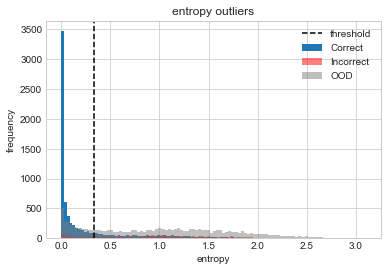

[0.3331862]
accepted OOD 2378
accepted ID 6142
accepted Correct 5760 :Acc 0.9378052751546727


In [155]:
df['entropy'] = df['Entropy']
df_OOD['entropy'] = df_OOD['Entropy']
Correct = df.loc[df["correct"]==True]
Incorrect = df.loc[df["correct"]==False]
_threshold = brevis.evaluate.calc_AUC(df, metrics=["entropy"],plot = False)
metric = "entropy"
_ = plt.hist(Correct[metric].tolist(), bins=100)  # arguments are passed to np.histogram
_ = plt.hist(Incorrect[metric].tolist(), bins=100,color ="red", alpha = 0.5)  # arguments are passed to np.histogram
_ = plt.hist(df_OOD[metric].tolist(), bins=100,color="grey",alpha=0.5)  # arguments are passed to np.histogram
plt.axvline(x=_threshold, color='k', linestyle='--',label="threshold")
plt.title(metric + " outliers")
plt.legend(["threshold","Correct","Incorrect","OOD"])
plt.xlabel("entropy")
plt.ylabel("frequency")
plt.show()
print(_threshold)
print("accepted OOD",len(df_OOD.loc[df_OOD[metric]<=_threshold[0]]))
print("accepted ID",len(df.loc[df[metric]<=_threshold[0]]))
print("accepted Correct",len(Correct.loc[df[metric]<=_threshold[0]]),":Acc", len(Correct.loc[df[metric]<=_threshold[0]])/len(df.loc[df[metric]<=_threshold[0]]))

max 2.963740825653076
[0.         0.33333333 0.66666667 1.         1.33333333 1.66666667
 2.         2.33333333 2.66666667 3.        ]
[7, 6143, 7132, 8015, 8913, 9446, 9789, 9942, 9989, 10000]


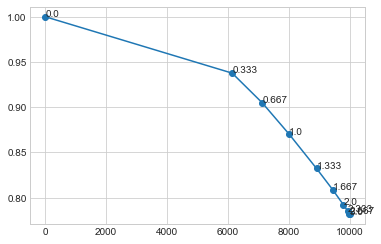

In [132]:
def cumulativeClassification(y, prob, bins =10, thresholdType = ">="):
    from sklearn.datasets import make_classification
    from sklearn.svm import SVC
    from sklearn.calibration import CalibratedClassifierCV
    from sklearn.model_selection import train_test_split
    from sklearn.calibration import calibration_curve
    from matplotlib import pyplot
    print("max",max(prob))
    linspace = np.linspace(0,math.ceil(max(prob)),num=bins)
    print(linspace)
    # pyplot.hist(prob,bins=linspace,density=False)
    accuracy = []
    throughputs = []
    for point in linspace:
        true = 0
        false = 0   
        throughput = 0
        for i, p in enumerate(prob):
            
            if thresholdType == ">=":
                if p >= point:
                    throughput = throughput + 1
                    if y[i] ==True:
                        true = true +1
                    if y[i] ==False: 
                        false = false + 1
            else:
                if p <= point:
                    throughput = throughput + 1
                    if y[i] ==True:
                        true = true +1
                    if y[i] ==False: 
                        false = false + 1
        try:
            accuracy.append(true/(true+false))
            throughputs.append(throughput)
            # print(point, throughput/len(prob))                
        except:
            accuracy.append(0)
            throughputs.append(0)
            pass
    # print(throughputs)
    pyplot.plot( throughputs,accuracy ,label="Accepted (y) for threshold (x)")
    pyplot.scatter(throughputs,accuracy)
    for i, txt in enumerate(np.round(linspace,3)):
        pyplot.annotate(txt, (throughputs[i], accuracy[i]))
    print(throughputs)
    # fop, mpv = calibration_curve(y,prob, n_bins=bins, normalize=True)
    # # plot calibrated reliability
    # # pyplot.plot(mpv, fop, marker='.',label="calibration")
    # # fop, mpv = calibration_curve(y,prob, n_bins=bins, normalize=True)
    # # plot perfectly calibrated
    # # pyplot.plot([0, 1], [0, 1], linestyle='--')
    # # plot calibrated reliability
    # pyplot.plot(linspace[:len(accuracy)], accuracy, marker='.',color='blue',label="Accuracy")
    # pyplot.legend(loc="upper right")
    # pyplot.legend(bbox_to_anchor=(1.1, 1.05))
    # pyplot.xlabel('Probability/Evidence')
    # pyplot.set_ylabel('Rating')
    
    pyplot.show()
    return throughputs, accuracy

import math
throughputs, accuracy = cumulativeClassification(df['correct'],df['entropy'],thresholdType="<=")

0.33


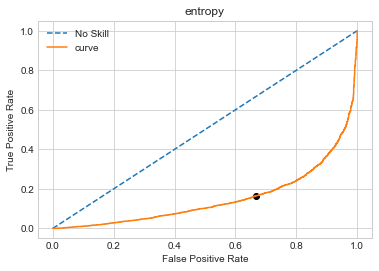

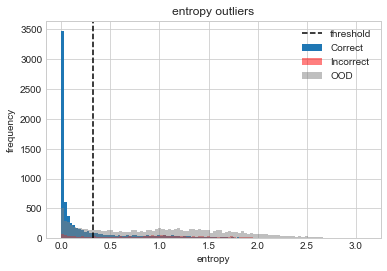

0.33
accepted OOD 2367
accepted ID 6128
accepted Correct 5749 :Acc 0.9381527415143603


In [133]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, precision_recall_curve, plot_precision_recall_curve
from numpy import sqrt


Correct = df.loc[df["correct"]==True]
Incorrect = df.loc[df["correct"]==False]
metric = "entropy"

pos_label = 1
### calc gmean threshold
y_test = np.int32(df['correct'])
lr_auc = roc_auc_score(y_test, df[metric])
fpr, tpr, thresholds = roc_curve(y_test, df[metric],pos_label=pos_label)
gmeans = sqrt(tpr * (1-fpr))
ix = np.argmax(gmeans)
# _threshold = thresholds[ix]
# print(metric," lr_auc",lr_auc, 'Best Threshold={}, G-Mean={}, TPR={}, FPR={}'.format(_threshold, gmeans[ix],tpr[ix],fpr[ix]))


# _threshold = Correct[metric].mean() + Correct[metric].std()
_threshold = 0.33
print(_threshold)
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr,  label="curve")

plt.scatter(fpr[ix], tpr[ix], marker='o', color='black')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(metric)
plt.legend()
# show the plot
plt.show()
# _threshold = brevis.evaluate.calc_AUC(df, metrics=[metric],plot = False)

_ = plt.hist(Correct[metric].tolist(), bins=100)  # arguments are passed to np.histogram
_ = plt.hist(Incorrect[metric].tolist(), bins=100,color ="red", alpha = 0.5)  # arguments are passed to np.histogram
_ = plt.hist(df_OOD[metric].tolist(), bins=100,color="grey",alpha=0.5)  # arguments are passed to np.histogram
plt.axvline(x=_threshold, color='k', linestyle='--',label="threshold")
plt.title(metric + " outliers")
plt.legend(["threshold","Correct","Incorrect","OOD"])
plt.xlabel("entropy")
plt.ylabel("frequency")
plt.show()
print(_threshold)
print("accepted OOD",len(df_OOD.loc[df_OOD[metric]<=_threshold]))
print("accepted ID",len(df.loc[df[metric]<=_threshold]))
print("accepted Correct",len(Correct.loc[df[metric]<=_threshold]),":Acc", len(Correct.loc[df[metric]<=_threshold])/len(df.loc[df[metric]<=_threshold]))

metric:  entropy threshold:  PR_AUC


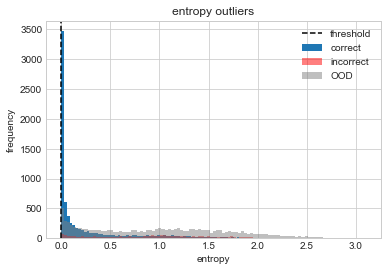

['exit_1']
  Exit_Name  ID_Inputs  OOD_Inputs  Test_Accuracy  Threshold  Accepted ID  Accepted OOD  Accepted_Correct  Accepted_ID_Ratio  Acceptance_Accuracy
0    exit_1      10000       10000         0.7815   0.003668         2186           151              2163           0.935387             0.925546
metric:  entropy threshold:  gmean
entropy  lr_auc 0.15096005891387068 Best Threshold=0.33318620920181274, G-Mean=0.7800802749149782, TPR=0.825629290617849, FPR=0.2629558541266795


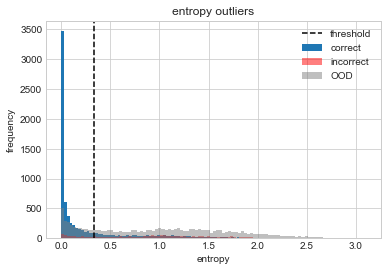

['exit_1']
  Exit_Name  ID_Inputs  OOD_Inputs  Test_Accuracy  Threshold  Accepted ID  Accepted OOD  Accepted_Correct  Accepted_ID_Ratio  Acceptance_Accuracy
0    exit_1      10000       10000         0.7815   0.333186         6142          2378              5760           0.720892             0.676056
metric:  entropy threshold:  0.333


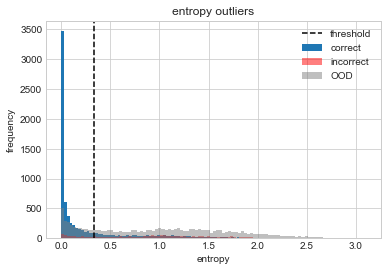

['exit_1']
  Exit_Name  ID_Inputs  OOD_Inputs  Test_Accuracy  Threshold  Accepted ID  Accepted OOD  Accepted_Correct  Accepted_ID_Ratio  Acceptance_Accuracy
0    exit_1      10000       10000         0.7815      0.333         6141          2378              5760           0.720859             0.676136


In [160]:
evaluate.buildCompareDistribPlot([df], [df_OOD], ["entropy"], "PR_AUC",main_exit_included=False,plot=True)
evaluate.buildCompareDistribPlot([df], [df_OOD], ["entropy"], "gmean",main_exit_included=False,plot=True)
evaluate.buildCompareDistribPlot([df], [df_OOD], ["entropy"], .333,main_exit_included=False,plot=True)

Entropy  lr_auc 0.15096005891387068 Best Threshold=0.33318620920181274, G-Mean=0.7800802749149782, TPR=0.825629290617849, FPR=0.2629558541266795


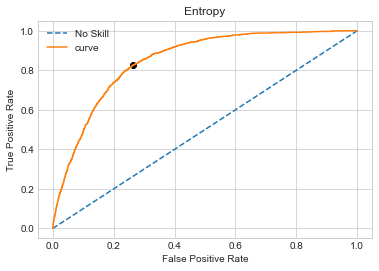

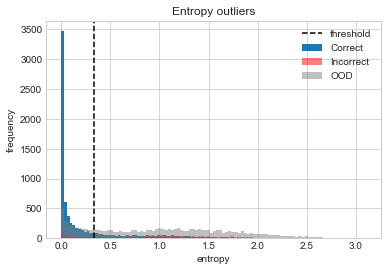

0.3331862
accepted OOD 2378
accepted ID 6142
accepted Correct 5760 :Acc 0.9378052751546727


In [163]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, precision_recall_curve, plot_precision_recall_curve
from numpy import sqrt


Correct = df.loc[df["correct"]==True]
Incorrect = df.loc[df["correct"]==False]
metric = "Entropy"

pos_label = 0
### calc gmean threshold
y_test = np.int32(df['correct'])
lr_auc = roc_auc_score(y_test, df[metric])
fpr, tpr, thresholds = roc_curve(y_test, df[metric],pos_label=pos_label)
gmeans = sqrt(tpr * (1-fpr))
ix = np.argmax(gmeans)
_threshold = thresholds[ix]
print(metric," lr_auc",lr_auc, 'Best Threshold={}, G-Mean={}, TPR={}, FPR={}'.format(_threshold, gmeans[ix],tpr[ix],fpr[ix]))
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr,  label="curve")

plt.scatter(fpr[ix], tpr[ix], marker='o', color='black')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(metric)
plt.legend()
# show the plot
plt.show()
# _threshold = brevis.evaluate.calc_AUC(df, metrics=[metric],plot = False)

_ = plt.hist(Correct[metric].tolist(), bins=100)  # arguments are passed to np.histogram
_ = plt.hist(Incorrect[metric].tolist(), bins=100,color ="red", alpha = 0.5)  # arguments are passed to np.histogram
_ = plt.hist(df_OOD[metric].tolist(), bins=100,color="grey",alpha=0.5)  # arguments are passed to np.histogram
plt.axvline(x=_threshold, color='k', linestyle='--',label="threshold")
plt.title(metric + " outliers")
plt.legend(["threshold","Correct","Incorrect","OOD"])
plt.xlabel("entropy")
plt.ylabel("frequency")
plt.show()
print(_threshold)
print("accepted OOD",len(df_OOD.loc[df_OOD[metric]<=_threshold]))
print("accepted ID",len(df.loc[df[metric]<=_threshold]))
print("accepted Correct",len(Correct.loc[df[metric]<=_threshold]),":Acc", len(Correct.loc[df[metric]<=_threshold])/len(df.loc[df[metric]<=_threshold]))

Entropy2  lr_auc 0.19174748773846467 Best Threshold=3.2700893878936768, G-Mean=0.2738551708075654, TPR=0.26270207852193994, FPR=0.7145182291666666


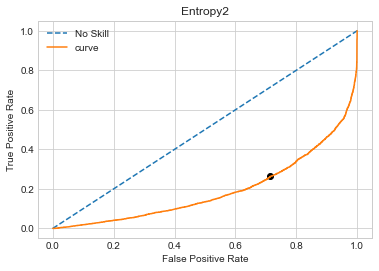

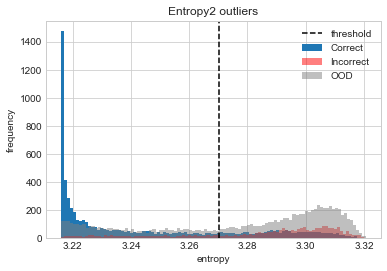

3.2700894
accepted OOD 3566
accepted ID 5986
accepted Correct 5109 :Acc 0.8534914801202806


In [53]:
Correct = df.loc[df["correct"]==True]
Incorrect = df.loc[df["correct"]==False]
metric = "Entropy2"

pos_label = 1
### calc gmean threshold
y_test = np.int32(df['correct'])
lr_auc = roc_auc_score(y_test, df[metric])
fpr, tpr, thresholds = roc_curve(y_test, df[metric],pos_label=pos_label)
gmeans = sqrt(tpr * (1-fpr))
ix = np.argmax(gmeans)
_threshold = thresholds[ix]
print(metric," lr_auc",lr_auc, 'Best Threshold={}, G-Mean={}, TPR={}, FPR={}'.format(_threshold, gmeans[ix],tpr[ix],fpr[ix]))
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr,  label="curve")

plt.scatter(fpr[ix], tpr[ix], marker='o', color='black')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(metric)
plt.legend()
# show the plot
plt.show()

# _threshold = brevis.evaluate.calc_AUC(df, metrics=["Entropy"],plot = False)
_ = plt.hist(Correct[metric].tolist(), bins=100)  # arguments are passed to np.histogram
_ = plt.hist(Incorrect[metric].tolist(), bins=100,color ="red", alpha = 0.5)  # arguments are passed to np.histogram
_ = plt.hist(df_OOD[metric].tolist(), bins=100,color="grey",alpha=0.5)  # arguments are passed to np.histogram
plt.axvline(x=_threshold, color='k', linestyle='--',label="threshold")
plt.title(metric + " outliers")
plt.legend(["threshold","Correct","Incorrect","OOD"])
plt.xlabel("entropy")
plt.ylabel("frequency")
plt.show()
print(_threshold)
print("accepted OOD",len(df_OOD.loc[df_OOD[metric]<=_threshold]))
print("accepted ID",len(df.loc[df[metric]<=_threshold]))
print("accepted Correct",len(Correct.loc[df[metric]<=_threshold]),":Acc", len(Correct.loc[df[metric]<=_threshold])/len(df.loc[df[metric]<=_threshold]))

In [62]:


def iad_loss(lambda_callback: lambda_update):
    def tfgamma(x):
        return tf.exp(tf.math.lgamma(x))    

    def EDL_info(labels, logits):
        evidence = tf.nn.softplus(logits)
        alpha = evidence + 1

        S = tf.reduce_sum(alpha,axis=1,keepdims=True) 
        E = alpha - 1
        m = alpha / S
        A = tf.reduce_sum((p-m)**2, axis=1, keepdims=True) 
        B = tf.reduce_sum(alpha*(S-alpha)/(S*S*(S+1)), axis=1, keepdims=True) 
        # tf.print(annealing_coef)
        # annealing_coef = 
        annealing_coef =  lambda_callback.lambda_t
        # annealing_coef =  0.0001
        alp = E*(1-p) + 1 
        C =   annealing_coef * KL(alp,10)
        # return (A + B) + C
        
        loss = (A+B)
        evidence = tf.nn.softplus(logits)
        alpha = evidence+1
        bool_mask = tf.cast(labels,tf.bool)
        ic_mask = tf.cast(1 - labels,tf.bool)
        ic_bool_mask = tf.cast(ic_mask,tf.bool)

        ic_alpha_masked = tf.cast(tf.ragged.boolean_mask(alpha, ic_bool_mask).to_tensor(),tf.float32)
        
        
        #### info reg
        _A = (ic_alpha_masked -1) ** 2
        B_1 = tf.math.polygamma(1.,ic_alpha_masked) 
        B_2 = tf.math.polygamma(1., tf.reduce_sum(ic_alpha_masked,axis=1,keepdims=True))
        # print(B_1)
        # print(B_2)
        _B = (B_1 - B_2)
        info_reg =  .5* tf.reduce_sum(_A * _B,axis=1)
        info_reg = annealing_coef * info_reg
        
        return loss + info_reg 
    
    
    def mse_loss(labels, logits):
        evidence = tf.nn.softmax(logits)
        alpha = evidence 
        squared_error = (alpha - labels) ** 2
        sum_squared_error = tf.reduce_sum(squared_error)
        loss = sum_squared_error / 10
        # tf.print(sum_squared_error)
        return loss
    
    return EDL_info

# def MAEBM(lambda_callback: lambda_update):
#     def MAEBM_loss(labels, outputs):
#         n_classes=10
#         evidence = exp_evidence(outputs)
#         alpha = evidence + 1
#         soft_output= labels
#         S = tf.reduce_sum(alpha,axis=1,keepdims=True)
#         alpha_0 = S * tf.ones((outputs.shape[-1]))
#         UCE_loss = tf.reduce_mean(
#             tf.cast(soft_output,dtype=tf.float32) * (tf.compat.v1.digamma(alpha_0) - tf.compat.v1.digamma(alpha))
#         )
#         annealing_coef =  lambda_callback.lambda_t
#         dirichlet_weight = 0.1 * tf.reduce_mean(-tfp.distributions.Dirichlet(alpha).entropy())
#         UCE_loss = (
#             UCE_loss + dirichlet_weight
#         )
#         return UCE_loss
#     return MAEBM_loss



def cross_energy(lambda_callback: lambda_update):
    #create a wrapper function that returns a function
    def cross_entropy_evidence(labels, outputs): 
        softmax = tf.nn.softmax(outputs)
        
        evidence = exp_evidence(outputs)
        alpha = evidence + 1
        S = tf.reduce_sum(alpha, axis=1, keepdims=True) 
        E = alpha - 1
        m = alpha / S
        A = tf.reduce_sum(labels * (tf.compat.v1.digamma(S) - tf.compat.v1.digamma(alpha)), axis=1, keepdims=True)
        B = tf.reduce_sum(alpha*(S-alpha)/(S*S*(S+1)), axis=1, keepdims=True) 
        alp = E*(1-labels) + 1 
        loss = tf.keras.losses.categorical_crossentropy(labels,softmax)
        annealing_rate =  lambda_callback.lambda_t
        # beta=tf.constant(np.ones((1,10)),dtype=tf.float32)
        # C =  annealing_rate * KL(alp,10)
        #A = annealing_rate * A
        
        Ec_in = -tf.math.reduce_logsumexp(outputs)
        # Ec_in = -torch.logsumexp(x[:len(in_set[0])], dim=1)
        # tf.print(0.1*(pow(tf.nn.relu(Ec_in- (-23)), 2)))
        # energy_loss = 0.1*(pow(tf.nn.relu(Ec_in- (-23)), 2)) #+ torch.pow(F.relu(args.m_out-Ec_out), 2).mean()) OLD METHOD< DID WORSE THEN ENERGY on EDL
        
        #so what about EDL + energy? 
        # val = y_hat * tf.math.log(y_hat)/tf.math.log(tf.constant(2, dtype=y_hat.dtype))
        # sumEntropies =  tf.reduce_sum(tf.boolean_mask(val,tf.math.is_finite(val)))
        energy_loss = annealing_rate * Ec_in
        
        # return loss + energy_loss #+  C
        return (A + B) + energy_loss 
    return  cross_entropy_evidence

def loss_wrapper(lambda_callback: lambda_update):
    ''' Loss function of Evidential Dirichlet Networks
        Expected Mean Square Error + KL divergence
    '''
    def custom_loss_function(p, logits):
    #     alpha = alpha + 1
        evidence = exp_evidence(logits)
        # evidence = tf.nn.softplus(logits)
        alpha = evidence + 1
        S = tf.reduce_sum(alpha,axis=1,keepdims=True) 
        E = alpha - 1
        m = alpha / S
        A = tf.reduce_sum((p-m)**2, axis=1, keepdims=True) 
        B = tf.reduce_sum(alpha*(S-alpha)/(S*S*(S+1)), axis=1, keepdims=True) 
        annealing_coef =  lambda_callback.lambda_t
        
        bool_mask = tf.cast(p,tf.bool)
        ic_mask = tf.cast(1 - p,tf.bool)
        ic_bool_mask = tf.cast(ic_mask,tf.bool)
        ic_alpha_masked = tf.cast(tf.ragged.boolean_mask(alpha, ic_bool_mask).to_tensor(),tf.float32)
        #### info reg
        _A = (ic_alpha_masked -1) ** 2
        B_1 = tf.math.polygamma(1.,ic_alpha_masked) 
        B_2 = tf.math.polygamma(1., tf.reduce_sum(ic_alpha_masked,axis=1,keepdims=True))
        _B = (B_1 - B_2)
        info_reg =  .5* tf.reduce_sum(_A * _B,axis=1)
        info_reg = annealing_coef * (info_reg * 2)
        
        # annealing_coef =  0.0001
        alp = E*(1-p) + 1 
        # C =   annealing_coef * KL(alp,10)
        C =   annealing_coef * DirichletKLLoss(p,logits, True)
        D = 0.0001 * -tf.reduce_mean(tfp.distributions.Dirichlet(alpha).entropy())
        return (A + B) + info_reg + D  #+ info_reg #+ C + D
    return custom_loss_function

# model = tf.keras.models.load_model('./models/resnet50_finetuned_brev.hdf5')
lambda_callback = lambda_update(10,0,max_t = .5, starting_epoch =1)


class growth_update(lambda_update):
    ''' callback update method that checks the performance of the model against the validation set to decide if the annealing coef should be increased.
        provides greater control of the additional loss elements by updating their hyperparameters inteligently, rather then with only a preset schedule.
        
    '''
    def __init__(self, annealing_max,  lambda_t=0, max_t=1, starting_epoch = 0):
        self.starting_epoch = starting_epoch
        self.start_val = tf.Variable(initial_value=lambda_t, dtype=tf.float32) 
        
        self.step = tf.Variable(initial_value = 0,dtype=tf.float32)
        self.lambda_t = tf.Variable(initial_value=lambda_t, dtype=tf.float32) #updates each epoch
        self.max_t = tf.Variable(initial_value=max_t, dtype=tf.float32)
        self.annealing_max = tf.Variable(initial_value=annealing_max, dtype=tf.float32)
        
        
        self.training = tf.Variable(initial_value=False, dtype=tf.bool)              
        self.past_val_acc= tf.Variable(initial_value =0, dtype=tf.float32)
        self.val_acc= tf.Variable(initial_value =0, dtype=tf.float32)
        
    def on_training_begin(self, logs={}):
        ''' indicate that training has begun, so val growth is an option.
        '''
        tf.print("training commenced, validation growth enabled")
        self.training.assign(True)
#     def on_training_end(self, logs={}):
#         ''' indicate that training has ended, so turn off val growth. Not sure if this is actually needed...
#         '''
#         tf.print("training commenced, validation growth enabled")
#         self.training.assign(False)
    def on_epoch_begin(self, epoch, logs={}): #needs to be on begin, otherwise the epoch update won't increase the value from 0 to 0.1 till the 3rd epoch...
        val = self.lambda_t
        if epoch >= self.starting_epoch:
            if self.val_acc >= self.past_val_acc:
                
                val = tf.reduce_min([self.max_t, tf.cast((self.step - self.starting_epoch) +self.start_val , tf.dtypes.float32) / tf.cast(self.annealing_max, tf.dtypes.float32)])
                tf.print("annealing coef updated to:", val)
                self.lambda_t.assign(val)
                self.past_val_acc.assign(self.val_acc)
                self.step.assign(self.step + 1)
            else:
                tf.print("val acc did not improve from {}, annealing coef not updated, remains at:{}".format(self.past_val_acc.numpy(), val.numpy()))
     # tf.print("past val acc =", self.past_val_acc)
        # self.past_val_acc.assign(self.val_acc)
        
    def on_test_end(self, logs=None):
        """ if training, save the performance results
        """
        self.val_acc.assign(logs.get('accuracy'))
        
        
   

        
def auxLoss(lambda_callback: lambda_update):
    def auxloss(p, logits):
        evidence = exp_evidence(logits)
            # evidence = tf.nn.softplus(logits)
        alpha = evidence + 1
        S = tf.reduce_sum(alpha,axis=1,keepdims=True) 
        E = alpha - 1
        m = alpha / S
        A = tf.reduce_sum((p-m)**2, axis=1, keepdims=True) 
        B = tf.reduce_sum(alpha*(S-alpha)/(S*S*(S+1)), axis=1, keepdims=True) 
        annealing_coef =  lambda_callback.lambda_t

        bool_mask = tf.cast(p,tf.bool)
        ic_mask = tf.cast(1 - p,tf.bool)
        ic_bool_mask = tf.cast(ic_mask,tf.bool)
        ic_alpha_masked = tf.cast(tf.ragged.boolean_mask(alpha, ic_bool_mask).to_tensor(),tf.float32)
        #### info reg
        _A = (ic_alpha_masked -1) ** 2
        B_1 = tf.math.polygamma(1.,ic_alpha_masked) 
        B_2 = tf.math.polygamma(1., tf.reduce_sum(ic_alpha_masked,axis=1,keepdims=True))
        _B = (B_1 - B_2)
        info_reg =  .5* tf.reduce_sum(_A * _B,axis=1)
        info_reg = annealing_coef * (info_reg * 2)

        alp = E*(1-p) + 1 
        # else:
            # tf.print("metric",annealing_coef)
        # C =   annealing_coef * KL(alp,10)
        C =   annealing_coef * DirichletKLLoss(p,logits, True)
        D = 0.0001 * -tf.reduce_mean(tfp.distributions.Dirichlet(alpha).entropy())
        # return (A + B) + C #+ D #+ info_reg #+ C + D
        tf.print(C)
        return tf.reduce_mean(info_reg+ D )
    return auxloss     


base_model = tf.keras.applications.resnet50.ResNet50(input_shape=(32, 32, 3),
     weights='imagenet',include_top=False)
x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(1024, activation="relu")(x)
x = tf.keras.layers.Dense(512, activation="relu")(x)
x = tf.keras.layers.Dense(10, name="classification")(x)

model = tf.keras.models.Model(inputs=base_model.input, outputs=x)



growth_callback = growth_update(100,0.,max_t = 0.1, starting_epoch =0)

auxlossMetric = auxLoss(growth_callback)
loss_fn = loss_wrapper(growth_callback)
# loss_fn = iad_loss(lambda_callback)
# loss_fn = tf.keras.losses.CategoricalCrossentropy(from_logits=False)

# model.compile(optimizer=tf.optimizers.SGD(learning_rate=0.01, momentum=0.9),
#                 loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
#                 metrics = ['accuracy'])
# model.fit(train_ds, validation_data=validation_ds,epochs = 1,callbacks=[lambda_callback])

model.compile(optimizer=tf.optimizers.SGD(learning_rate=0.01, momentum=0.9),
                loss=loss_fn,
                metrics = ['accuracy',auxlossMetric ])
model.fit(train_ds, validation_data=validation_ds,epochs = 5,callbacks=[growth_callback])




annealing coef updated to: 0
Epoch 1/5
1407/1407 [==============================] - 81s 54ms/step - loss: 0.6467 - accuracy: 0.4855 - auxloss: 0.0028 - val_loss: 0.5402 - val_accuracy: 0.6050 - val_auxloss: 0.0035
annealing coef updated to: 0.01
Epoch 2/5
1407/1407 [==============================] - 79s 56ms/step - loss: 0.4824 - accuracy: 0.7007 - auxloss: 0.0305 - val_loss: 0.6094 - val_accuracy: 0.6118 - val_auxloss: 0.0293
annealing coef updated to: 0.02
Epoch 3/5
1407/1407 [==============================] - 75s 53ms/step - loss: 0.4168 - accuracy: 0.7492 - auxloss: 0.0307 - val_loss: 0.5170 - val_accuracy: 0.6754 - val_auxloss: 0.0358
annealing coef updated to: 0.03
Epoch 4/5
1407/1407 [==============================] - 79s 56ms/step - loss: 0.3868 - accuracy: 0.7769 - auxloss: 0.0356 - val_loss: 0.4660 - val_accuracy: 0.7196 - val_auxloss: 0.0439
annealing coef updated to: 0.04
Epoch 5/5
1407/1407 [==============================] - 75s 53ms/step - loss: 0.3517 - accuracy: 0.8026 

In [65]:
base_model = model
# 0    exit_1      10000       10000         0.6634 -36.302174         5713          2951              4843           0.659395              0.55898

In [84]:
        
def auxLoss(lambda_callback: lambda_update):
    def auxloss(p, logits):
        evidence = exp_evidence(logits)
            # evidence = tf.nn.softplus(logits)
        alpha = evidence + 1
        S = tf.reduce_sum(alpha,axis=1,keepdims=True) 
        E = alpha - 1
        m = alpha / S
        A = tf.reduce_sum((p-m)**2, axis=1, keepdims=True) 
        B = tf.reduce_sum(alpha*(S-alpha)/(S*S*(S+1)), axis=1, keepdims=True) 
        annealing_coef =  lambda_callback.lambda_t

        bool_mask = tf.cast(p,tf.bool)
        ic_mask = tf.cast(1 - p,tf.bool)
        ic_bool_mask = tf.cast(ic_mask,tf.bool)
        ic_alpha_masked = tf.cast(tf.ragged.boolean_mask(alpha, ic_bool_mask).to_tensor(),tf.float32)
        #### info reg
        _A = (ic_alpha_masked -1) ** 2
        B_1 = tf.math.polygamma(1.,ic_alpha_masked) 
        B_2 = tf.math.polygamma(1., tf.reduce_sum(ic_alpha_masked,axis=1,keepdims=True))
        _B = (B_1 - B_2)
        info_reg =  .5* tf.reduce_sum(_A * _B,axis=1)
        info_reg = annealing_coef * (info_reg * 2)
        
        alp = E*(1-p) + 1 
        # else:
            # tf.print("metric",annealing_coef)
        # C =   annealing_coef * KL(alp,10)
        C =   annealing_coef * DirichletKLLoss(p,logits, True)
        D = 0.0001 * -tf.reduce_mean(tfp.distributions.Dirichlet(alpha).entropy())
        # return (A + B) + C #+ D #+ info_reg #+ C + D
        # tf.print(info_reg)
        return tf.reduce_mean(info_reg+ D )
    return auxloss     

growth_callback = growth_update(10,1.,max_t = 0.1, starting_epoch =0)

auxlossMetric = auxLoss(growth_callback)
loss_fn = loss_wrapper(growth_callback)
# loss_fn = iad_loss(lambda_callback)
# loss_fn = tf.keras.losses.CategoricalCrossentropy(from_logits=False)

# model.compile(optimizer=tf.optimizers.SGD(learning_rate=0.01, momentum=0.9),
#                 loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
#                 metrics = ['accuracy'])
# model.fit(train_ds, validation_data=validation_ds,epochs = 1,callbacks=[lambda_callback])

model.compile(optimizer=tf.optimizers.SGD(learning_rate=0.01, momentum=0.9),
                loss=loss_fn,
                metrics = ['accuracy',auxlossMetric ])
model.fit(train_ds, validation_data=validation_ds,epochs = 1,callbacks=[growth_callback])

annealing coef updated to: 0.1
1407/1407 [==============================] - 81s 54ms/step - loss: 0.5457 - accuracy: 0.7170 - auxloss: 0.0774 - val_loss: 1.0692 - val_accuracy: 0.3706 - val_auxloss: 0.2005


In [89]:
model.compile(optimizer=tf.optimizers.SGD(learning_rate=0.01, momentum=0.9),
                loss=loss_fn,
                metrics = ['accuracy',auxlossMetric ])
model.fit(train_ds, validation_data=validation_ds,epochs = 5,callbacks=[growth_callback])

annealing coef updated to: 0.1
Epoch 1/5
1407/1407 [==============================] - 82s 54ms/step - loss: 0.2456 - accuracy: 0.8768 - auxloss: 0.0412 - val_loss: 0.3918 - val_accuracy: 0.8016 - val_auxloss: 0.0776
annealing coef updated to: 0.1
Epoch 2/5
1407/1407 [==============================] - 75s 53ms/step - loss: 0.2107 - accuracy: 0.8932 - auxloss: 0.0357 - val_loss: 0.3921 - val_accuracy: 0.8050 - val_auxloss: 0.0766
annealing coef updated to: 0.1
Epoch 3/5
1407/1407 [==============================] - 75s 53ms/step - loss: 0.1836 - accuracy: 0.9053 - auxloss: 0.0310 - val_loss: 0.4041 - val_accuracy: 0.8024 - val_auxloss: 0.0827
val acc did not improve from 0.8050000071525574, annealing coef not updated, remains at:0.10000000149011612
Epoch 4/5
1407/1407 [==============================] - 75s 53ms/step - loss: 0.1637 - accuracy: 0.9159 - auxloss: 0.0282 - val_loss: 0.3974 - val_accuracy: 0.8058 - val_auxloss: 0.0821
annealing coef updated to: 0.1
Epoch 5/5
1407/1407 [=======

In [ ]:
model.evaluate(test_ds)

In [90]:
output_ID= getPredictions_Energy(model, test_ds,stopping_point=None)
for i in output_ID:
    i['outlier']=0
print("----")
output_OOD = getPredictions_Energy(model, test_ds100,stopping_point=None)
for i in output_OOD:
    i['correct']=0
    i['outlier']=1
    


----iction: 312 of 313


metric:  energy threshold:  gmean
energy  lr_auc 0.15328315019891964 Best Threshold=-49.84635543823242, G-Mean=0.7841320990649159, TPR=0.8113396889111891, FPR=0.24216310728112903


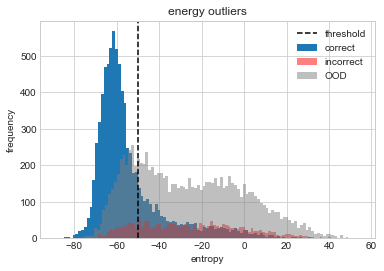

['exit_1']
  Exit_Name  ID_Inputs  OOD_Inputs  Test_Accuracy  Threshold  Accepted ID  Accepted OOD  Accepted_Correct  Accepted_ID_Ratio  Acceptance_Accuracy
0    exit_1      10000       10000         0.8007 -49.846355         6445          2335              6068           0.734055             0.691116
metric:  energy threshold:  PR_AUC


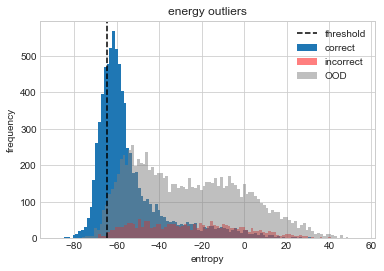

['exit_1']
  Exit_Name  ID_Inputs  OOD_Inputs  Test_Accuracy  Threshold  Accepted ID  Accepted OOD  Accepted_Correct  Accepted_ID_Ratio  Acceptance_Accuracy
0    exit_1      10000       10000         0.8007 -64.530914         1994           257              1960           0.885829             0.870724


In [91]:
evaluate.buildCompareDistribPlot(output_ID, output_OOD, ["energy"], "gmean",main_exit_included=False,plot=True)
evaluate.buildCompareDistribPlot(output_ID, output_OOD, ["energy"], "PR_AUC",main_exit_included=False,plot=True)

metric:  energy threshold:  gmean
energy  lr_auc 0.16894683333333332 Best Threshold=-34.75727844238281, G-Mean=0.7615942551804139, TPR=0.8006666666666666, FPR=0.2755714285714286


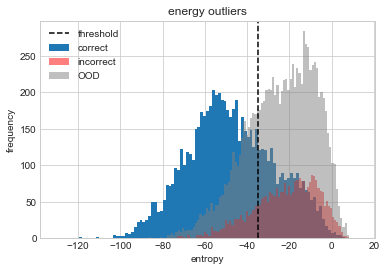

['exit_1']
  Exit_Name  ID_Inputs  OOD_Inputs  Test_Accuracy  Threshold  Accepted ID  Accepted OOD  Accepted_Correct  Accepted_ID_Ratio  Acceptance_Accuracy
0    exit_1      10000       10000            0.7 -34.757278         5670          2622              5071           0.683792             0.611553
metric:  energy threshold:  PR_AUC


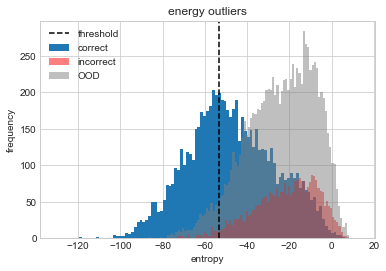

['exit_1']
  Exit_Name  ID_Inputs  OOD_Inputs  Test_Accuracy  Threshold  Accepted ID  Accepted OOD  Accepted_Correct  Accepted_ID_Ratio  Acceptance_Accuracy
0    exit_1      10000       10000            0.7 -53.117771         3001           528              2897           0.850383             0.820912


In [232]:
evaluate.buildCompareDistribPlot(output_ID, output_OOD, ["energy"], "gmean",main_exit_included=False,plot=True)
evaluate.buildCompareDistribPlot(output_ID, output_OOD, ["energy"], "PR_AUC",main_exit_included=False,plot=True)

In [ ]:
output_ID= getPredictions_Energy(model, test_ds,stopping_point=None)
for i in output_ID:
    i['outlier']=0
print("----")
output_OOD = getPredictions_Energy(model, test_ds100,stopping_point=None)
for i in output_OOD:
    i['correct']=0
    i['outlier']=1
    


----iction: 312 of 313


max -729.4473876953125
[   0.          -81.11111111 -162.22222222 -243.33333333 -324.44444444
 -405.55555556 -486.66666667 -567.77777778 -648.88888889 -730.        ]
[10000, 7897, 5246, 2934, 1328, 524, 168, 34, 8, 0]


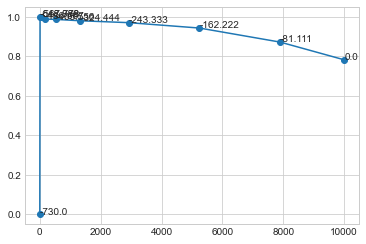

In [142]:
def cumulativeClassification(y, prob, bins =10, thresholdType = ">="):
    from sklearn.datasets import make_classification
    from sklearn.svm import SVC
    from sklearn.calibration import CalibratedClassifierCV
    from sklearn.model_selection import train_test_split
    from sklearn.calibration import calibration_curve
    from matplotlib import pyplot
    print("max",min(prob))
    linspace = np.linspace(0,math.floor(min(prob)),num=bins)
    print(linspace)
    # pyplot.hist(prob,bins=linspace,density=False)
    accuracy = []
    throughputs = []
    for point in linspace:
        true = 0
        false = 0   
        throughput = 0
        for i, p in enumerate(prob):
            
            if thresholdType == ">=":
                if p >= point:
                    throughput = throughput + 1
                    if y[i] ==True:
                        true = true +1
                    if y[i] ==False: 
                        false = false + 1
            else:
                if p <= point:
                    throughput = throughput + 1
                    if y[i] ==True:
                        true = true +1
                    if y[i] ==False: 
                        false = false + 1
        try:
            accuracy.append(true/(true+false))
            throughputs.append(throughput)
            # print(point, throughput/len(prob))                
        except:
            accuracy.append(0)
            throughputs.append(0)
            pass
    # print(throughputs)
    pyplot.plot( throughputs,accuracy ,label="Accepted (y) for threshold (x)")
    pyplot.scatter(throughputs,accuracy)
    for i, txt in enumerate(np.round(linspace,3)):
        pyplot.annotate(txt, (throughputs[i], accuracy[i]))
    print(throughputs)
    # fop, mpv = calibration_curve(y,prob, n_bins=bins, normalize=True)
    # # plot calibrated reliability
    # # pyplot.plot(mpv, fop, marker='.',label="calibration")
    # # fop, mpv = calibration_curve(y,prob, n_bins=bins, normalize=True)
    # # plot perfectly calibrated
    # # pyplot.plot([0, 1], [0, 1], linestyle='--')
    # # plot calibrated reliability
    # pyplot.plot(linspace[:len(accuracy)], accuracy, marker='.',color='blue',label="Accuracy")
    # pyplot.legend(loc="upper right")
    # pyplot.legend(bbox_to_anchor=(1.1, 1.05))
    # pyplot.xlabel('Probability/Evidence')
    # pyplot.set_ylabel('Rating')
    
    pyplot.show()
    return throughputs, accuracy

import math
# throughputs, accuracy = cumulativeClassification(df['correct'],df['entropy'],thresholdType="<=")

throughputs, accuracy = cumulativeClassification(output_ID[0]['correct'],output_ID[0]['energy'],bins=10,thresholdType="<=")

metric:  energy threshold:  PR_AUC


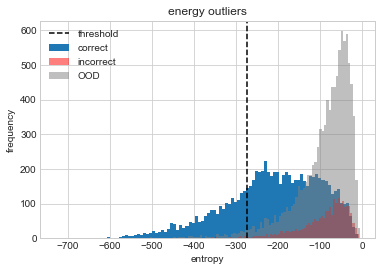

['exit_1']
  Exit_Name  ID_Inputs  OOD_Inputs  Test_Accuracy   Threshold  Accepted ID  Accepted OOD  Accepted_Correct  Accepted_ID_Ratio  Acceptance_Accuracy
0    exit_1      10000       10000         0.7822 -273.589935         2179           264              2122           0.891936             0.868604
metric:  energy threshold:  gmean
energy  lr_auc 0.1752927980438963 Best Threshold=-132.71755981445312, G-Mean=0.7576113595068498, TPR=0.7947658402203857, FPR=0.27780618767578624


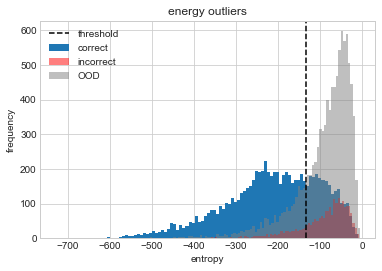

['exit_1']
  Exit_Name  ID_Inputs  OOD_Inputs  Test_Accuracy  Threshold  Accepted ID  Accepted OOD  Accepted_Correct  Accepted_ID_Ratio  Acceptance_Accuracy
0    exit_1      10000       10000         0.7822 -132.71756         6097          2014              5649           0.751695             0.696462
metric:  energy threshold:  -162


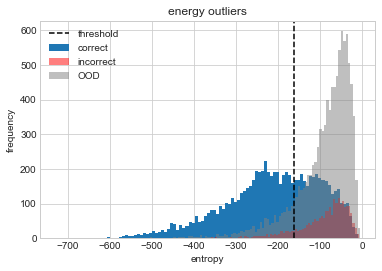

['exit_1']
  Exit_Name  ID_Inputs  OOD_Inputs  Test_Accuracy  Threshold  Accepted ID  Accepted OOD  Accepted_Correct  Accepted_ID_Ratio  Acceptance_Accuracy
0    exit_1      10000       10000         0.7822     -162.0         5253          1304              4953           0.801129             0.755376


In [156]:
# 5 epochs at .01 annealing, then 5 epochs at .1
evaluate.buildCompareDistribPlot(output_ID, output_OOD, ["energy"], "PR_AUC",main_exit_included=False,plot=True)
evaluate.buildCompareDistribPlot(output_ID, output_OOD, ["energy"], "gmean",main_exit_included=False,plot=True)
evaluate.buildCompareDistribPlot(output_ID, output_OOD, ["energy"], -162,main_exit_included=False,plot=True)

metric:  energy threshold:  gmean
energy  lr_auc 0.18537724991674437 Best Threshold=-128.23216247558594, G-Mean=0.7419971883458804, TPR=0.7906877402819308, FPR=0.30369499934717326


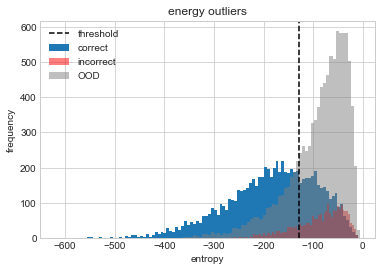

['exit_1']
  Exit_Name  ID_Inputs  OOD_Inputs  Test_Accuracy   Threshold  Accepted ID  Accepted OOD  Accepted_Correct  Accepted_ID_Ratio  Acceptance_Accuracy
0    exit_1      10000       10000         0.7659 -128.232162         5824          2155              5333           0.729916             0.668379


In [19]:
evaluate.buildCompareDistribPlot(output_ID, output_OOD, ["energy"], "gmean",main_exit_included=False,plot=True)

metric:  energy threshold:  gmean
energy  lr_auc 0.1752927980438963 Best Threshold=-132.71755981445312, G-Mean=0.7576113595068498, TPR=0.7947658402203857, FPR=0.27780618767578624


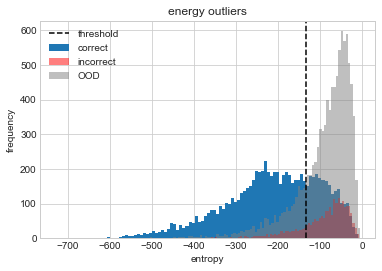

['exit_1']
  Exit_Name  ID_Inputs  OOD_Inputs  Test_Accuracy  Threshold  Accepted ID  Accepted OOD  Accepted_Correct  Accepted_ID_Ratio  Acceptance_Accuracy
0    exit_1      10000       10000         0.7822 -132.71756         6097          2014              5649           0.751695             0.696462


In [170]:
evaluate.buildCompareDistribPlot(output_ID, output_OOD, ["energy"], "gmean",main_exit_included=False,plot=True)

metric:  uncert threshold:  gmean
uncert  lr_auc 0.3299632972292836 Best Threshold=0.0004593504873825303, G-Mean=0.7339705118752079, TPR=0.6538108356290174, FPR=0.1760419330094605


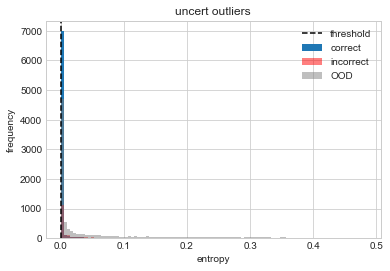

['exit_1']
  Exit_Name  ID_Inputs  OOD_Inputs  Test_Accuracy  Threshold  Accepted ID  Accepted OOD  Accepted_Correct  Accepted_ID_Ratio  Acceptance_Accuracy
0    exit_1      10000       10000         0.7822   0.000459         7200          3270              6445           0.687679             0.615568


In [172]:
evaluate.buildCompareDistribPlot(output_ID, output_OOD, ["uncert"], "gmean",main_exit_included=False,plot=True)

metric:  entropy threshold:  gmean
entropy  lr_auc 0.2468927539621662 Best Threshold=1.783702546523913e-36, G-Mean=0.7346039539868185, TPR=0.6508620689655172, FPR=0.17087967644084934


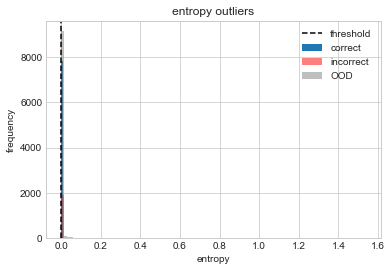

['exit_1']
  Exit_Name  ID_Inputs  OOD_Inputs  Test_Accuracy     Threshold  Accepted ID  Accepted OOD  Accepted_Correct  Accepted_ID_Ratio  Acceptance_Accuracy
0    exit_1      10000       10000         0.7912  1.783703e-36         7290          3549              6560           0.672571             0.605222
metric:  energy threshold:  gmean
energy  lr_auc 0.1834377142823937 Best Threshold=-131.56890869140625, G-Mean=0.75030743827592, TPR=0.774904214559387, FPR=0.2735085945399393


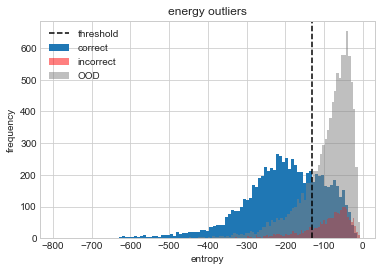

['exit_1']
  Exit_Name  ID_Inputs  OOD_Inputs  Test_Accuracy   Threshold  Accepted ID  Accepted OOD  Accepted_Correct  Accepted_ID_Ratio  Acceptance_Accuracy
0    exit_1      10000       10000         0.7912 -131.568909         6219          2177              5748            0.74071             0.684612


In [93]:
#4epochs at 0.01 + 10 at 0.1
# evaluate.calculateBranching(output_ID,threshold="gmean",metrics=["energy"],main_exit_included=False,plot=True)
evaluate.buildCompareDistribPlot(output_ID, output_OOD, ["entropy"], "gmean",main_exit_included=False,plot=True)
evaluate.buildCompareDistribPlot(output_ID, output_OOD, ["energy"], "gmean",main_exit_included=False,plot=True)

metric:  energy threshold:  gmean
energy  lr_auc 0.1727441119156941 Best Threshold=-199.75668334960938, G-Mean=0.7622932631522212, TPR=0.7642963699651915, FPR=0.2397045938164977


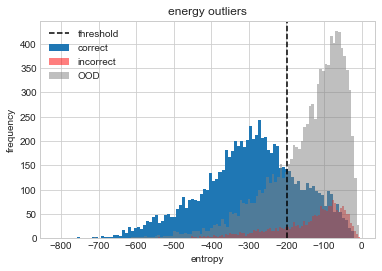

['exit_1']
  Exit_Name  ID_Inputs  OOD_Inputs  Test_Accuracy   Threshold  Accepted ID  Accepted OOD  Accepted_Correct  Accepted_ID_Ratio  Acceptance_Accuracy
0    exit_1      10000       10000         0.7989 -199.756683         6549          2440              6074           0.728557             0.675715


In [178]:
#4epochs training at 0.01
# evaluate.calculateBranching(output_ID,threshold="gmean",metrics=["energy"],main_exit_included=False,plot=True)
evaluate.buildCompareDistribPlot(output_ID, output_OOD, ["energy"], "gmean",main_exit_included=False,plot=True)

metric:  entropy threshold:  gmean
entropy  lr_auc 0.23768307655246593 Best Threshold=1.716824960742687e-36, G-Mean=0.745384185116108, TPR=0.6694214876033058, FPR=0.1700332395806699


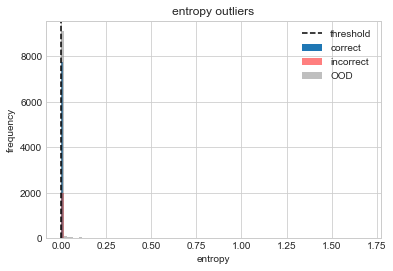

['exit_1']
  Exit_Name  ID_Inputs  OOD_Inputs  Test_Accuracy     Threshold  Accepted ID  Accepted OOD  Accepted_Correct  Accepted_ID_Ratio  Acceptance_Accuracy
0    exit_1      10000       10000         0.7822  1.716825e-36         7213          3494              6492           0.673671             0.606332
metric:  energy threshold:  gmean
energy  lr_auc 0.1752927980438963 Best Threshold=-132.71755981445312, G-Mean=0.7576113595068498, TPR=0.7947658402203857, FPR=0.27780618767578624


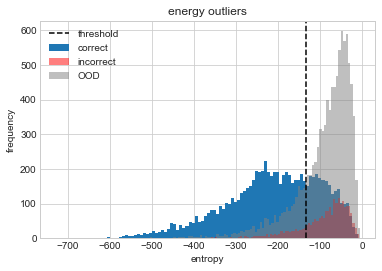

['exit_1']
  Exit_Name  ID_Inputs  OOD_Inputs  Test_Accuracy  Threshold  Accepted ID  Accepted OOD  Accepted_Correct  Accepted_ID_Ratio  Acceptance_Accuracy
0    exit_1      10000       10000         0.7822 -132.71756         6097          2014              5649           0.751695             0.696462


In [173]:
# 10epochs at 0.01 + 10 at 0.1
# evaluate.calculateBranching(output_ID,threshold="gmean",metrics=["energy"],main_exit_included=False,plot=True)
evaluate.buildCompareDistribPlot(output_ID, output_OOD, ["entropy"], "gmean",main_exit_included=False,plot=True)
evaluate.buildCompareDistribPlot(output_ID, output_OOD, ["energy"], "gmean",main_exit_included=False,plot=True)

metric:  entropy threshold:  gmean
entropy  lr_auc 0.17786251655851543 Best Threshold=3.2483572959899902, G-Mean=0.7509992188820357, TPR=0.7945154019534185, FPR=0.29013355137639685


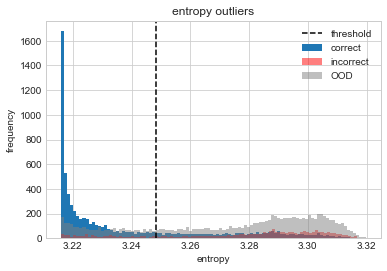

['exit_1']
  Exit_Name  ID_Inputs  OOD_Inputs  Test_Accuracy  Threshold  Accepted ID  Accepted OOD  Accepted_Correct  Accepted_ID_Ratio  Acceptance_Accuracy
0    exit_1      10000       10000         0.7338   3.248357         5757          2493              5209           0.697818             0.631394
metric:  energy threshold:  gmean
energy  lr_auc 0.1778849648782344 Best Threshold=-2.4399826526641846, G-Mean=0.7509929133997189, TPR=0.749060856498873, FPR=0.247070046334151


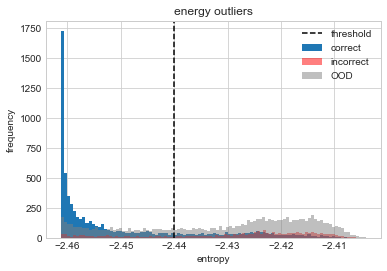

['exit_1']
  Exit_Name  ID_Inputs  OOD_Inputs  Test_Accuracy  Threshold  Accepted ID  Accepted OOD  Accepted_Correct  Accepted_ID_Ratio  Acceptance_Accuracy
0    exit_1      10000       10000         0.7338  -2.439983         6194          3070              5525            0.66861             0.596395


In [153]:
#cross entropy softmax, proof that CE can get much worse then EDL energy
# evaluate.calculateBranching(output_ID,threshold="gmean",metrics=["energy"],main_exit_included=False,plot=True)
evaluate.buildCompareDistribPlot(output_ID, output_OOD, ["entropy"], "gmean",main_exit_included=False,plot=True)
evaluate.buildCompareDistribPlot(output_ID, output_OOD, ["energy"], "gmean",main_exit_included=False,plot=True)

metric:  entropy threshold:  gmean
entropy  lr_auc 0.14646386340987888 Best Threshold=1.740739146981599e-18, G-Mean=0.7851111525425007, TPR=0.8556418455915943, FPR=0.27960568429138394


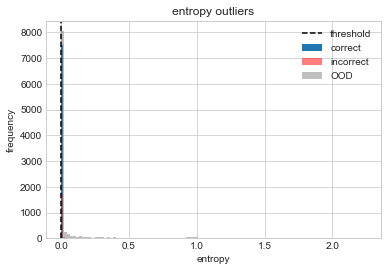

['exit_1']
  Exit_Name  ID_Inputs  OOD_Inputs  Test_Accuracy     Threshold  Accepted ID  Accepted OOD  Accepted_Correct  Accepted_ID_Ratio  Acceptance_Accuracy
0    exit_1      10000       10000         0.7811  1.740739e-18         5944          1830              5627             0.7646             0.723823
metric:  energy threshold:  gmean
energy  lr_auc 0.14429624759310572 Best Threshold=-29.752485275268555, G-Mean=0.7796373832130858, TPR=0.8328003654636821, FPR=0.2701318653181411


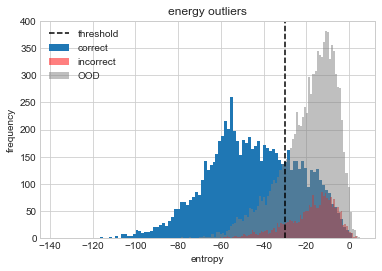

['exit_1']
  Exit_Name  ID_Inputs  OOD_Inputs  Test_Accuracy  Threshold  Accepted ID  Accepted OOD  Accepted_Correct  Accepted_ID_Ratio  Acceptance_Accuracy
0    exit_1      10000       10000         0.7811 -29.752485         6068          1932              5701             0.7585             0.712625


In [143]:
# evaluate.calculateBranching(output_ID,threshold="gmean",metrics=["energy"],main_exit_included=False,plot=True)
evaluate.buildCompareDistribPlot(output_ID, output_OOD, ["entropy"], "gmean",main_exit_included=False,plot=True)
evaluate.buildCompareDistribPlot(output_ID, output_OOD, ["energy"], "gmean",main_exit_included=False,plot=True)

### Cross Entropy Performance

metric:  entropy threshold:  gmean
entropy  lr_auc 0.19879774271968548 Best Threshold=3.2511117458343506, G-Mean=0.7343983604291425, TPR=0.779648871372268, FPR=0.30822582882507976


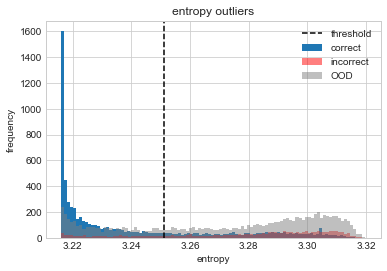

['exit_1']
  Exit_Name  ID_Inputs  OOD_Inputs  Test_Accuracy  Threshold  Accepted ID  Accepted OOD  Accepted_Correct  Accepted_ID_Ratio  Acceptance_Accuracy
0    exit_1      10000       10000         0.7209   3.251112         5603          2948              4987           0.655245             0.583207
metric:  energy threshold:  gmean
energy  lr_auc 0.19875621753313155 Best Threshold=-2.4430172443389893, G-Mean=0.7342510831068094, TPR=0.779648871372268, FPR=0.30850325981412124


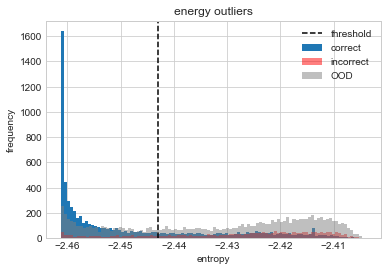

['exit_1']
  Exit_Name  ID_Inputs  OOD_Inputs  Test_Accuracy  Threshold  Accepted ID  Accepted OOD  Accepted_Correct  Accepted_ID_Ratio  Acceptance_Accuracy
0    exit_1      10000       10000         0.7209  -2.443017         5601          2940              4985           0.655778             0.583655


In [130]:
# evaluate.calculateBranching(output_ID,threshold="gmean",metrics=["energy"],main_exit_included=False,plot=True)
evaluate.buildCompareDistribPlot(output_ID, output_OOD, ["entropy"], "gmean",main_exit_included=False,plot=True)
evaluate.buildCompareDistribPlot(output_ID, output_OOD, ["energy"], "gmean",main_exit_included=False,plot=True)

### EDL Training

metric:  entropy threshold:  gmean
entropy  lr_auc 0.18212600844715707 Best Threshold=8.65280917945779e-25, G-Mean=0.7542142133891352, TPR=0.7925445705024311, FPR=0.2822623473181094


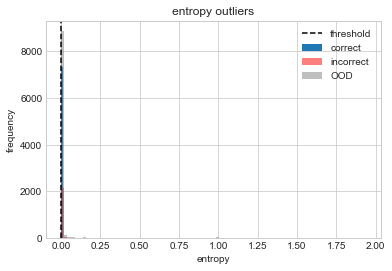

['exit_1']
  Exit_Name  ID_Inputs  OOD_Inputs  Test_Accuracy     Threshold  Accepted ID  Accepted OOD  Accepted_Correct  Accepted_ID_Ratio  Acceptance_Accuracy
0    exit_1      10000       10000         0.7532  8.652809e-25         5919          2377              5406           0.713476             0.651639
metric:  energy threshold:  gmean
energy  lr_auc 0.17521212572440784 Best Threshold=-35.827903747558594, G-Mean=0.754937222720766, TPR=0.8156401944894651, FPR=0.3012480084970791


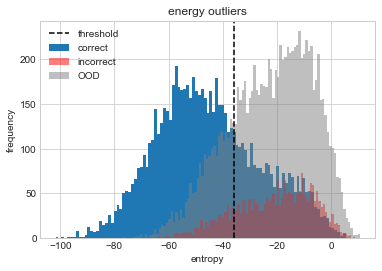

['exit_1']
  Exit_Name  ID_Inputs  OOD_Inputs  Test_Accuracy  Threshold  Accepted ID  Accepted OOD  Accepted_Correct  Accepted_ID_Ratio  Acceptance_Accuracy
0    exit_1      10000       10000         0.7532 -35.827904         5719          2125              5263           0.729092             0.670959


In [21]:
# evaluate.calculateBranching(output_ID,threshold="gmean",metrics=["energy"],main_exit_included=False,plot=True)
evaluate.buildCompareDistribPlot(output_ID, output_OOD, ["entropy"], "gmean",main_exit_included=False,plot=True)
evaluate.buildCompareDistribPlot(output_ID, output_OOD, ["energy"], "gmean",main_exit_included=False,plot=True)

### EDL increased KL annealing

metric:  entropy threshold:  gmean
entropy  lr_auc 0.16342349674238715 Best Threshold=2.318815373546744e-15, G-Mean=0.7682862307364291, TPR=0.7792103142626914, FPR=0.24248470337855813


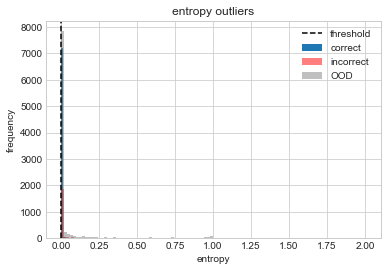

['exit_1']
  Exit_Name  ID_Inputs  OOD_Inputs  Test_Accuracy     Threshold  Accepted ID  Accepted OOD  Accepted_Correct  Accepted_ID_Ratio  Acceptance_Accuracy
0    exit_1      10000       10000         0.7518  2.318815e-15         6244          2429              5695           0.719935             0.656636
metric:  energy threshold:  gmean
energy  lr_auc 0.16128833105140733 Best Threshold=-9.191804885864258, G-Mean=0.768395319185881, TPR=0.815068493150685, FPR=0.2756052141527002


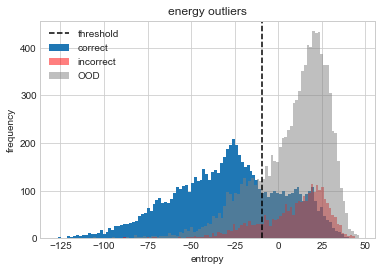

['exit_1']
  Exit_Name  ID_Inputs  OOD_Inputs  Test_Accuracy  Threshold  Accepted ID  Accepted OOD  Accepted_Correct  Accepted_ID_Ratio  Acceptance_Accuracy
0    exit_1      10000       10000         0.7518  -9.191805         5906          1997              5446           0.747311             0.689105


In [26]:
# evaluate.calculateBranching(output_ID,threshold="gmean",metrics=["energy"],main_exit_included=False,plot=True)
evaluate.buildCompareDistribPlot(output_ID, output_OOD, ["entropy"], "gmean",main_exit_included=False,plot=True)
evaluate.buildCompareDistribPlot(output_ID, output_OOD, ["energy"], "gmean",main_exit_included=False,plot=True)

metric:  entropy threshold:  gmean
entropy  lr_auc 0.19191644831822308 Best Threshold=7.664809213398917e-26, G-Mean=0.7424743819234184, TPR=0.8025055268975682, FPR=0.3130661542684601


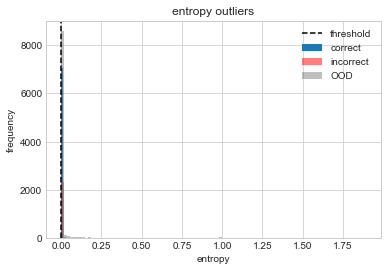

['exit_1']
  Exit_Name  ID_Inputs  OOD_Inputs  Test_Accuracy     Threshold  Accepted ID  Accepted OOD  Accepted_Correct  Accepted_ID_Ratio  Acceptance_Accuracy
0    exit_1      10000       10000         0.7286  7.664809e-26         5542          1963              5005           0.738441             0.666889
metric:  energy threshold:  gmean
energy  lr_auc 0.18621867155815727 Best Threshold=-35.19999313354492, G-Mean=0.739774921333588, TPR=0.7873986735445836, FPR=0.30496843261048584


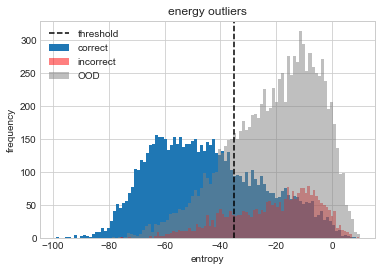

['exit_1']
  Exit_Name  ID_Inputs  OOD_Inputs  Test_Accuracy  Threshold  Accepted ID  Accepted OOD  Accepted_Correct  Accepted_ID_Ratio  Acceptance_Accuracy
0    exit_1      10000       10000         0.7286 -35.199993         5642          2022              5064           0.736169             0.660752


In [72]:
# evaluate.calculateBranching(output_ID,threshold="gmean",metrics=["energy"],main_exit_included=False,plot=True)
evaluate.buildCompareDistribPlot(output_ID, output_OOD, ["entropy"], "gmean",main_exit_included=False,plot=True)
evaluate.buildCompareDistribPlot(output_ID, output_OOD, ["energy"], "gmean",main_exit_included=False,plot=True)

metric:  entropy threshold:  gmean
entropy  lr_auc 0.1674143371258462 Best Threshold=1.9275404658350484e-19, G-Mean=0.7640685641593178, TPR=0.8227611940298507, FPR=0.29043715846994533


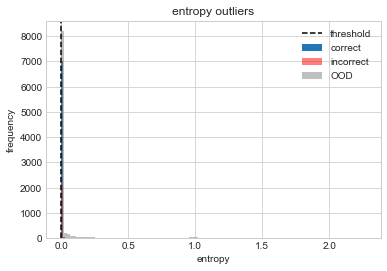

['exit_1']
  Exit_Name  ID_Inputs  OOD_Inputs  Test_Accuracy     Threshold  Accepted ID  Accepted OOD  Accepted_Correct  Accepted_ID_Ratio  Acceptance_Accuracy
0    exit_1      10000       10000          0.732  1.927540e-19         5670          2218              5194           0.718813             0.658469
metric:  energy threshold:  gmean
energy  lr_auc 0.158514140363755 Best Threshold=-11.301655769348145, G-Mean=0.7687079323422529, TPR=0.825, FPR=0.2837431693989071


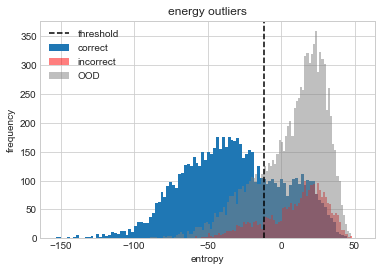

['exit_1']
  Exit_Name  ID_Inputs  OOD_Inputs  Test_Accuracy  Threshold  Accepted ID  Accepted OOD  Accepted_Correct  Accepted_ID_Ratio  Acceptance_Accuracy
0    exit_1      10000       10000          0.732 -11.301656         5713          2117              5243            0.72963             0.669604
metric:  uncert threshold:  gmean
uncert  lr_auc 0.15907432611532502 Best Threshold=0.7655292804130186, G-Mean=0.7687509013802127, TPR=0.8197761194029851, FPR=0.27909836065573773


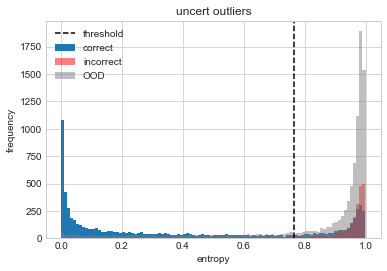

['exit_1']
  Exit_Name  ID_Inputs  OOD_Inputs  Test_Accuracy  Threshold  Accepted ID  Accepted OOD  Accepted_Correct  Accepted_ID_Ratio  Acceptance_Accuracy
0    exit_1      10000       10000          0.732   0.765529         5760          2170              5277           0.726356             0.665448
metric:  entropy_of_expected threshold:  gmean
entropy_of_expected  lr_auc 0.8412733463828399 Best Threshold=-2.135063388179983, G-Mean=0.7690091623344569, TPR=0.7158469945355191, FPR=0.17388059701492536


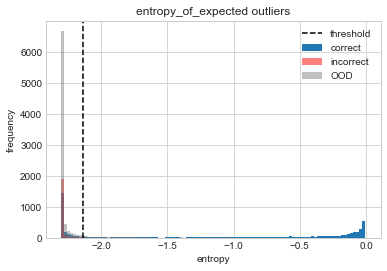

['exit_1']
  Exit_Name  ID_Inputs  OOD_Inputs  Test_Accuracy  Threshold  Accepted ID  Accepted OOD  Accepted_Correct  Accepted_ID_Ratio  Acceptance_Accuracy
0    exit_1      10000       10000          0.732  -2.135063         5706          2112              5240           0.729854             0.670248


In [82]:
#30 epochs, 10 at 0-.1 10 at .1-1, then 10 at annealing 1
# evaluate.calculateBranching(output_ID,threshold="gmean",metrics=["energy"],main_exit_included=False,plot=True)
evaluate.buildCompareDistribPlot(output_ID, output_OOD, ["entropy"], "gmean",main_exit_included=False,plot=True)
evaluate.buildCompareDistribPlot(output_ID, output_OOD, ["energy"], "gmean",main_exit_included=False,plot=True)
evaluate.buildCompareDistribPlot(output_ID, output_OOD, ["uncert"], "gmean",main_exit_included=False,plot=True)
evaluate.buildCompareDistribPlot(output_ID, output_OOD, ["entropy_of_expected"], "gmean",main_exit_included=False,plot=True)

#### Cross Energy 

metric:  energy threshold:  gmean
energy  lr_auc 0.21433627609176856 Best Threshold=-45.216060638427734, G-Mean=0.7116361224307385, TPR=0.7538167938931297, FPR=0.32818428184281845


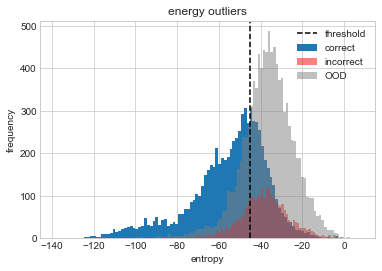

['exit_1']
  Exit_Name  ID_Inputs  OOD_Inputs  Test_Accuracy  Threshold  Accepted ID  Accepted OOD  Accepted_Correct  Accepted_ID_Ratio  Acceptance_Accuracy
0    exit_1      10000       10000          0.738 -45.216061         5604          2062              4958            0.73102             0.646752


In [86]:
#5 anealing 0-.5
evaluate.buildCompareDistribPlot(output_ID, output_OOD, ["energy"], "gmean",main_exit_included=False,plot=True)

metric:  energy threshold:  gmean
energy  lr_auc 0.26537344855106365 Best Threshold=-5.320924282073975, G-Mean=0.6713087186794758, TPR=0.7554129911788292, FPR=0.4034317637669593


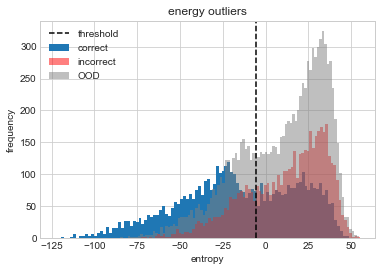

['exit_1']
  Exit_Name  ID_Inputs  OOD_Inputs  Test_Accuracy  Threshold  Accepted ID  Accepted OOD  Accepted_Correct  Accepted_ID_Ratio  Acceptance_Accuracy
0    exit_1      10000       10000         0.5012  -5.320924         4211          2864              2990           0.595194             0.422615
metric:  entropy threshold:  gmean
entropy  lr_auc 0.2709033004030103 Best Threshold=8.468915456916681e-16, G-Mean=0.6784350898790731, TPR=0.7720529270248596, FPR=0.4038308060654429


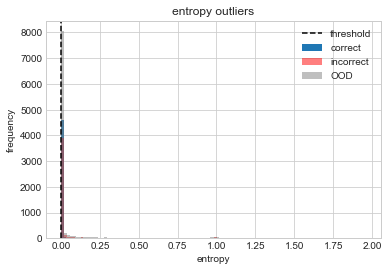

['exit_1']
  Exit_Name  ID_Inputs  OOD_Inputs  Test_Accuracy     Threshold  Accepted ID  Accepted OOD  Accepted_Correct  Accepted_ID_Ratio  Acceptance_Accuracy
0    exit_1      10000       10000         0.5012  8.468915e-16         4126          2757              2988           0.599448             0.434113


In [117]:
#5 anealing 0-.5, 10 annealing .1-1
evaluate.buildCompareDistribPlot(output_ID, output_OOD, ["energy"], "gmean",main_exit_included=False,plot=True)
evaluate.buildCompareDistribPlot(output_ID, output_OOD, ["entropy"], "gmean",main_exit_included=False,plot=True)